# Imports and setup

In [1]:
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt

import pickle

import arviz as az
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal

from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize

import sys
import importlib
sys.path.append('/Users/Tavangar/Work/stream-membership/')
sys.path.append('../../')
sys.path.append('/Users/Tavangar/Work/CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
    MixtureModel
)
# from gd1_helpers.membership.initialize import *
from scripts.gd1_init import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

/Users/Tavangar/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
cmap = plt.get_cmap('cmr.amber_r')
mpl.rc('image', cmap=cmap.name)
mpl.rc('image', cmap='gray_r')

In [3]:
data = at.Table.read("../../../CATS_Workshop/cats/data/joined-GD-1.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data[data['phot_g_mean_mag'] <20.5]
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']


stream='GD-1'
phi1_lim = (np.min(cat['phi1']), np.max(cat['phi1']))
phi1_lim = [-100,20]

cat = cat[(cat['phi1'] < phi1_lim[1]) & (cat['phi1'] > phi1_lim[0])] # clunky to hard code this

In [4]:
p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg,
                                      phi1_lim=phi1_lim)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-13.271475187973863, -3.1697646472516334, 0.5058218775428639, 0.3829921285438014] 

Producing the polygon and mask


In [5]:
# with open('../data/gd1_pawprint.pkl', 'wb') as output_file:
#     pickle.dump(p, output_file)

In [6]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}

# with open('../data/gd1_run_data.pkl', 'wb') as output_file:
#     pickle.dump(run_data, output_file)

bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

# with open('../data/gd1_bkg_data.pkl', 'wb') as output_file:
#     pickle.dump(bkg_data, output_file)

stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

# with open('../data/gd1_stream_data.pkl', 'wb') as output_file:
#     pickle.dump(stream_data, output_file)

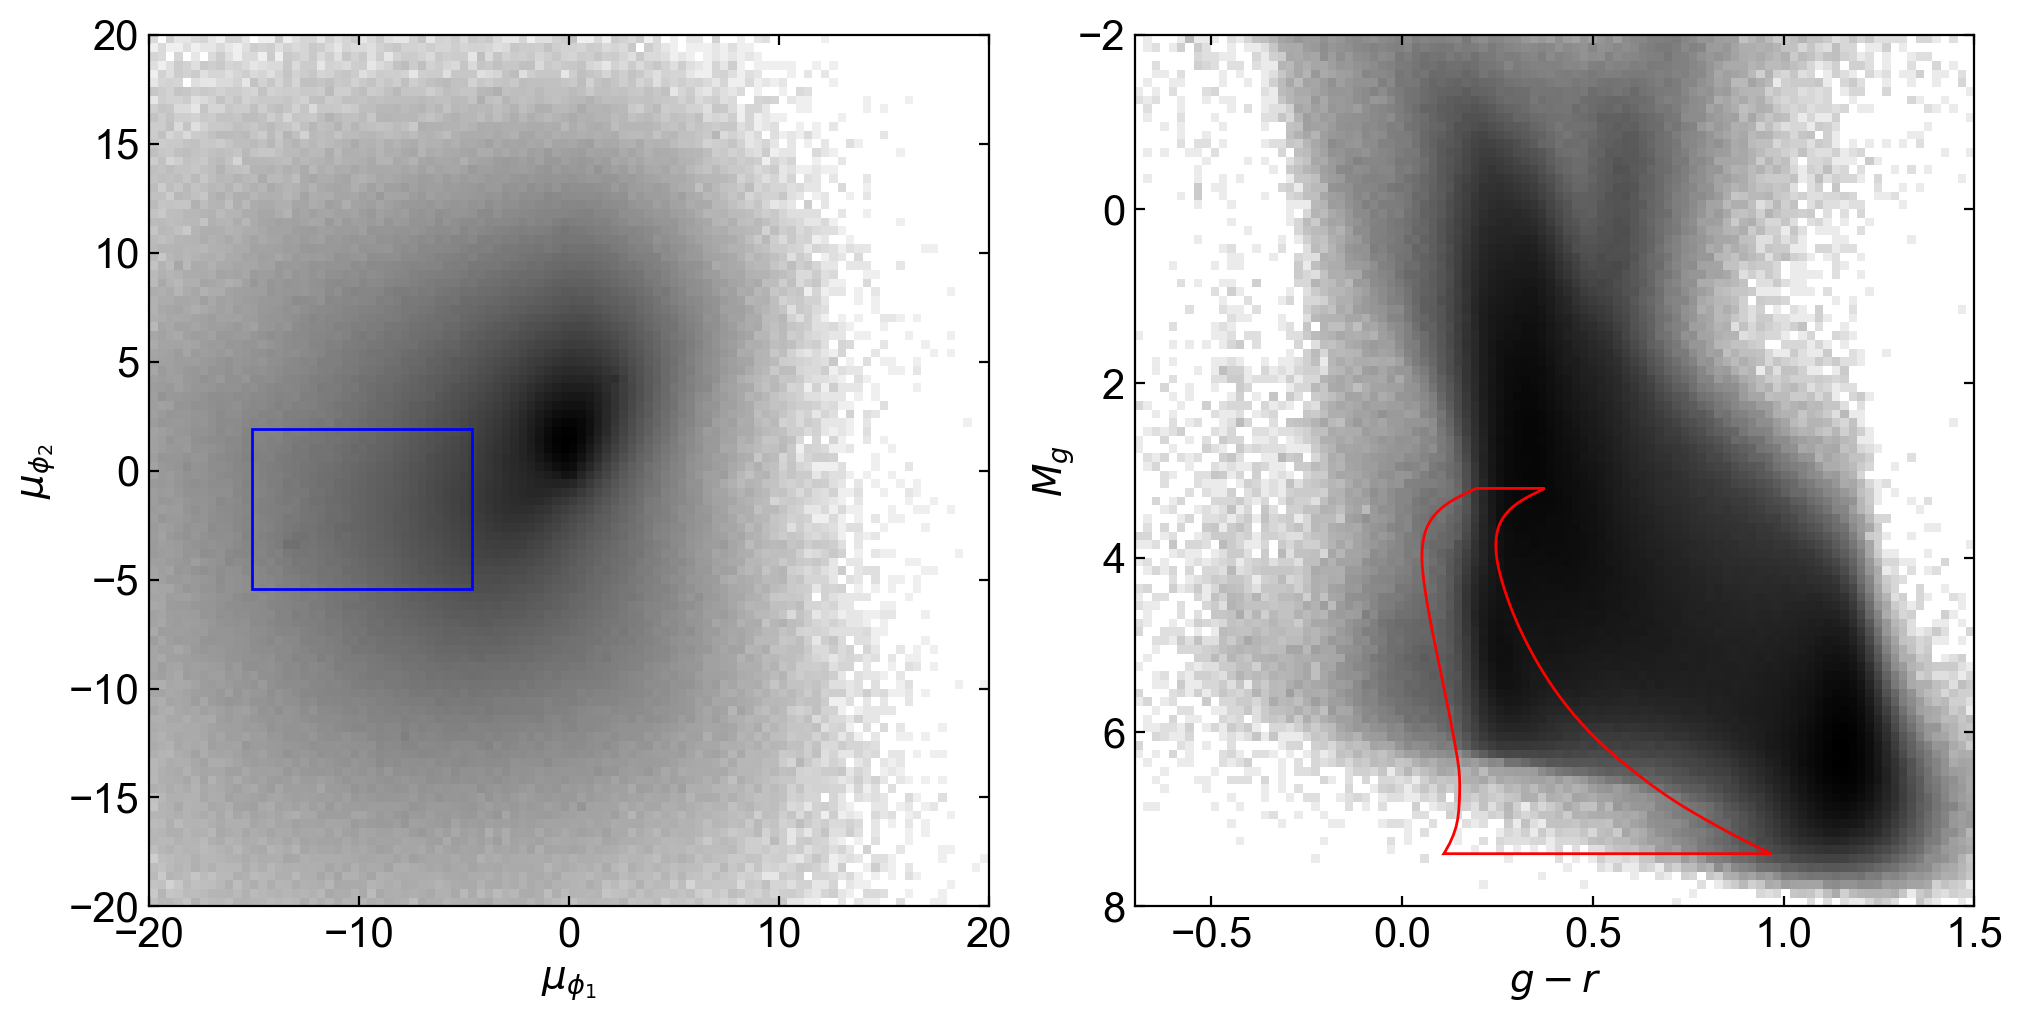

In [7]:
cmd_poly = o.pawprint.cmdprint.vertices - np.array([0,o.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, edgecolor="red", facecolor="none")

pm_poly = o.pawprint.pmprint.vertices
pm_patch = mpl.patches.Polygon(pm_poly, edgecolor="blue", facecolor="none")

distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(o.cat["phi1"]) - o.dist_mod

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
ax1.hist2d(o.cat['pm1'], o.cat['pm2'], cmap='gray_r', bins=100, range=[[-20,20],[-20,20]], 
           norm=mpl.colors.LogNorm(), rasterized=True)
ax1.add_patch(pm_patch)
ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)

ax2.hist2d(o.cat['g0'] - o.cat['r0'], o.cat['g0'] - dist_mod_correct_all  - o.dist_mod, 
           bins=100, range=[[-0.7,1.5],[-2,8]], norm=mpl.colors.LogNorm(), rasterized=True)
ax2.add_patch(cmd_patch)
ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(8, -2)

ax1.set_xlabel(r'$\mu_{\phi_1}$', fontsize=14)
ax1.set_ylabel(r'$\mu_{\phi_2}$', fontsize=14)

ax2.set_xlabel(r'$g-r$', fontsize=14)
ax2.set_ylabel(r'$M_g$', fontsize=14, labelpad=0.1)
plt.savefig('../../paper_figures/gd1_cuts.pdf')
plt.show()

In [8]:
patch_sky = mpl.patches.Polygon(
            o.pawprint.skyprint["stream"].vertices[::50],
            facecolor="r",
            edgecolor="r",
            linewidth=1,
            alpha=0.2
        )

spline_phi2, spline_pm1, spline_pm2, _ = pmsel.from_galstreams()

fig, axes, _ = plot_data_projections(data=run_data, grids=BkgModel.default_grids,
                      smooth=1, pcolormesh_kwargs={'rasterized':True});
axes[0].add_patch(patch_sky)
phi1_array = np.arange(-100, 20, 0.2)
axes[1].fill_between(phi1_array, spline_pm1(phi1_array)+np.exp(-0.5), spline_pm1(phi1_array)-np.exp(-0.5), 
                     color='r', alpha=0.2)
axes[2].fill_between(phi1_array, spline_pm2(phi1_array)+np.exp(-0.5), spline_pm2(phi1_array)-np.exp(-0.5), 
                     color='r', alpha=0.2)
# axes[1].add_patch(patch_pm1)
# axes[2].add_patch(patch_pm2)
# plt.savefig('../paper_figures/gd1_data.pdf')
plt.show()

NameError: name 'BkgModel' is not defined

# Background

In [8]:
BkgModel = make_bkg_model(BackgroundModel, p, cat, knot_sep=10, phi2_bkg=False)

In [9]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    #"phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    "phi1": {'zs': np.zeros(BkgModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(BkgModel.pm1_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm1_knots, 0),
        "ln_std1": np.full_like(BkgModel.pm1_knots, 1),
        "mean2": np.full_like(BkgModel.pm1_knots, 5),
        "ln_std2": np.full_like(BkgModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BkgModel.pm2_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm2_knots, -2.),
        "ln_std1": np.full_like(BkgModel.pm2_knots, 1),
        "mean2": np.full_like(BkgModel.pm2_knots, -3),
        "ln_std2": np.full_like(BkgModel.pm2_knots, 2)
    },
}

In [10]:
background_init = BkgModel(bkg_init_p)

### Optimization

In [11]:
bkg_opt_pars, bkg_info = background_init.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)

background_opt = BkgModel(bkg_opt_pars)
bkg_info

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0007299549541605627 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0007299549541605627 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. cr

LbfgsbState(iter_num=Array(15, dtype=int64, weak_type=True), value=Array(0.91562472, dtype=float64), grad={'ln_N': Array(-4.54729605e-05, dtype=float64), 'phi1': {'zs': Array([ 9.17457823e-05,  9.79874587e-05,  1.17118524e-04,  5.23402531e-05,
       -1.80530749e-04, -2.51173558e-04,  1.80606098e-05,  3.10484486e-04,
       -2.42212507e-04, -4.50064013e-04,  1.45045484e-04, -7.49789901e-05,
       -2.91690415e-04, -1.45065788e-04], dtype=float64)}, 'phi2': {}, 'pm1': {'ln_std1': Array([ 6.73807187e-07, -1.28124023e-04, -3.20641198e-04,  1.59663608e-06,
       -3.02704631e-04, -1.88351262e-04,  3.13361097e-04, -1.69190297e-04,
       -2.76047818e-04,  6.81758113e-05,  1.17904463e-04,  7.88582477e-05,
       -1.12561527e-04], dtype=float64), 'ln_std2': Array([ 6.61144947e-05,  7.08708005e-06, -1.65087978e-04, -4.44930004e-05,
       -1.95925007e-04, -1.87073616e-04,  1.05385606e-04, -1.30689429e-04,
       -2.70010046e-04, -8.12375944e-05, -3.02514074e-05, -6.61218879e-05,
        7.6633

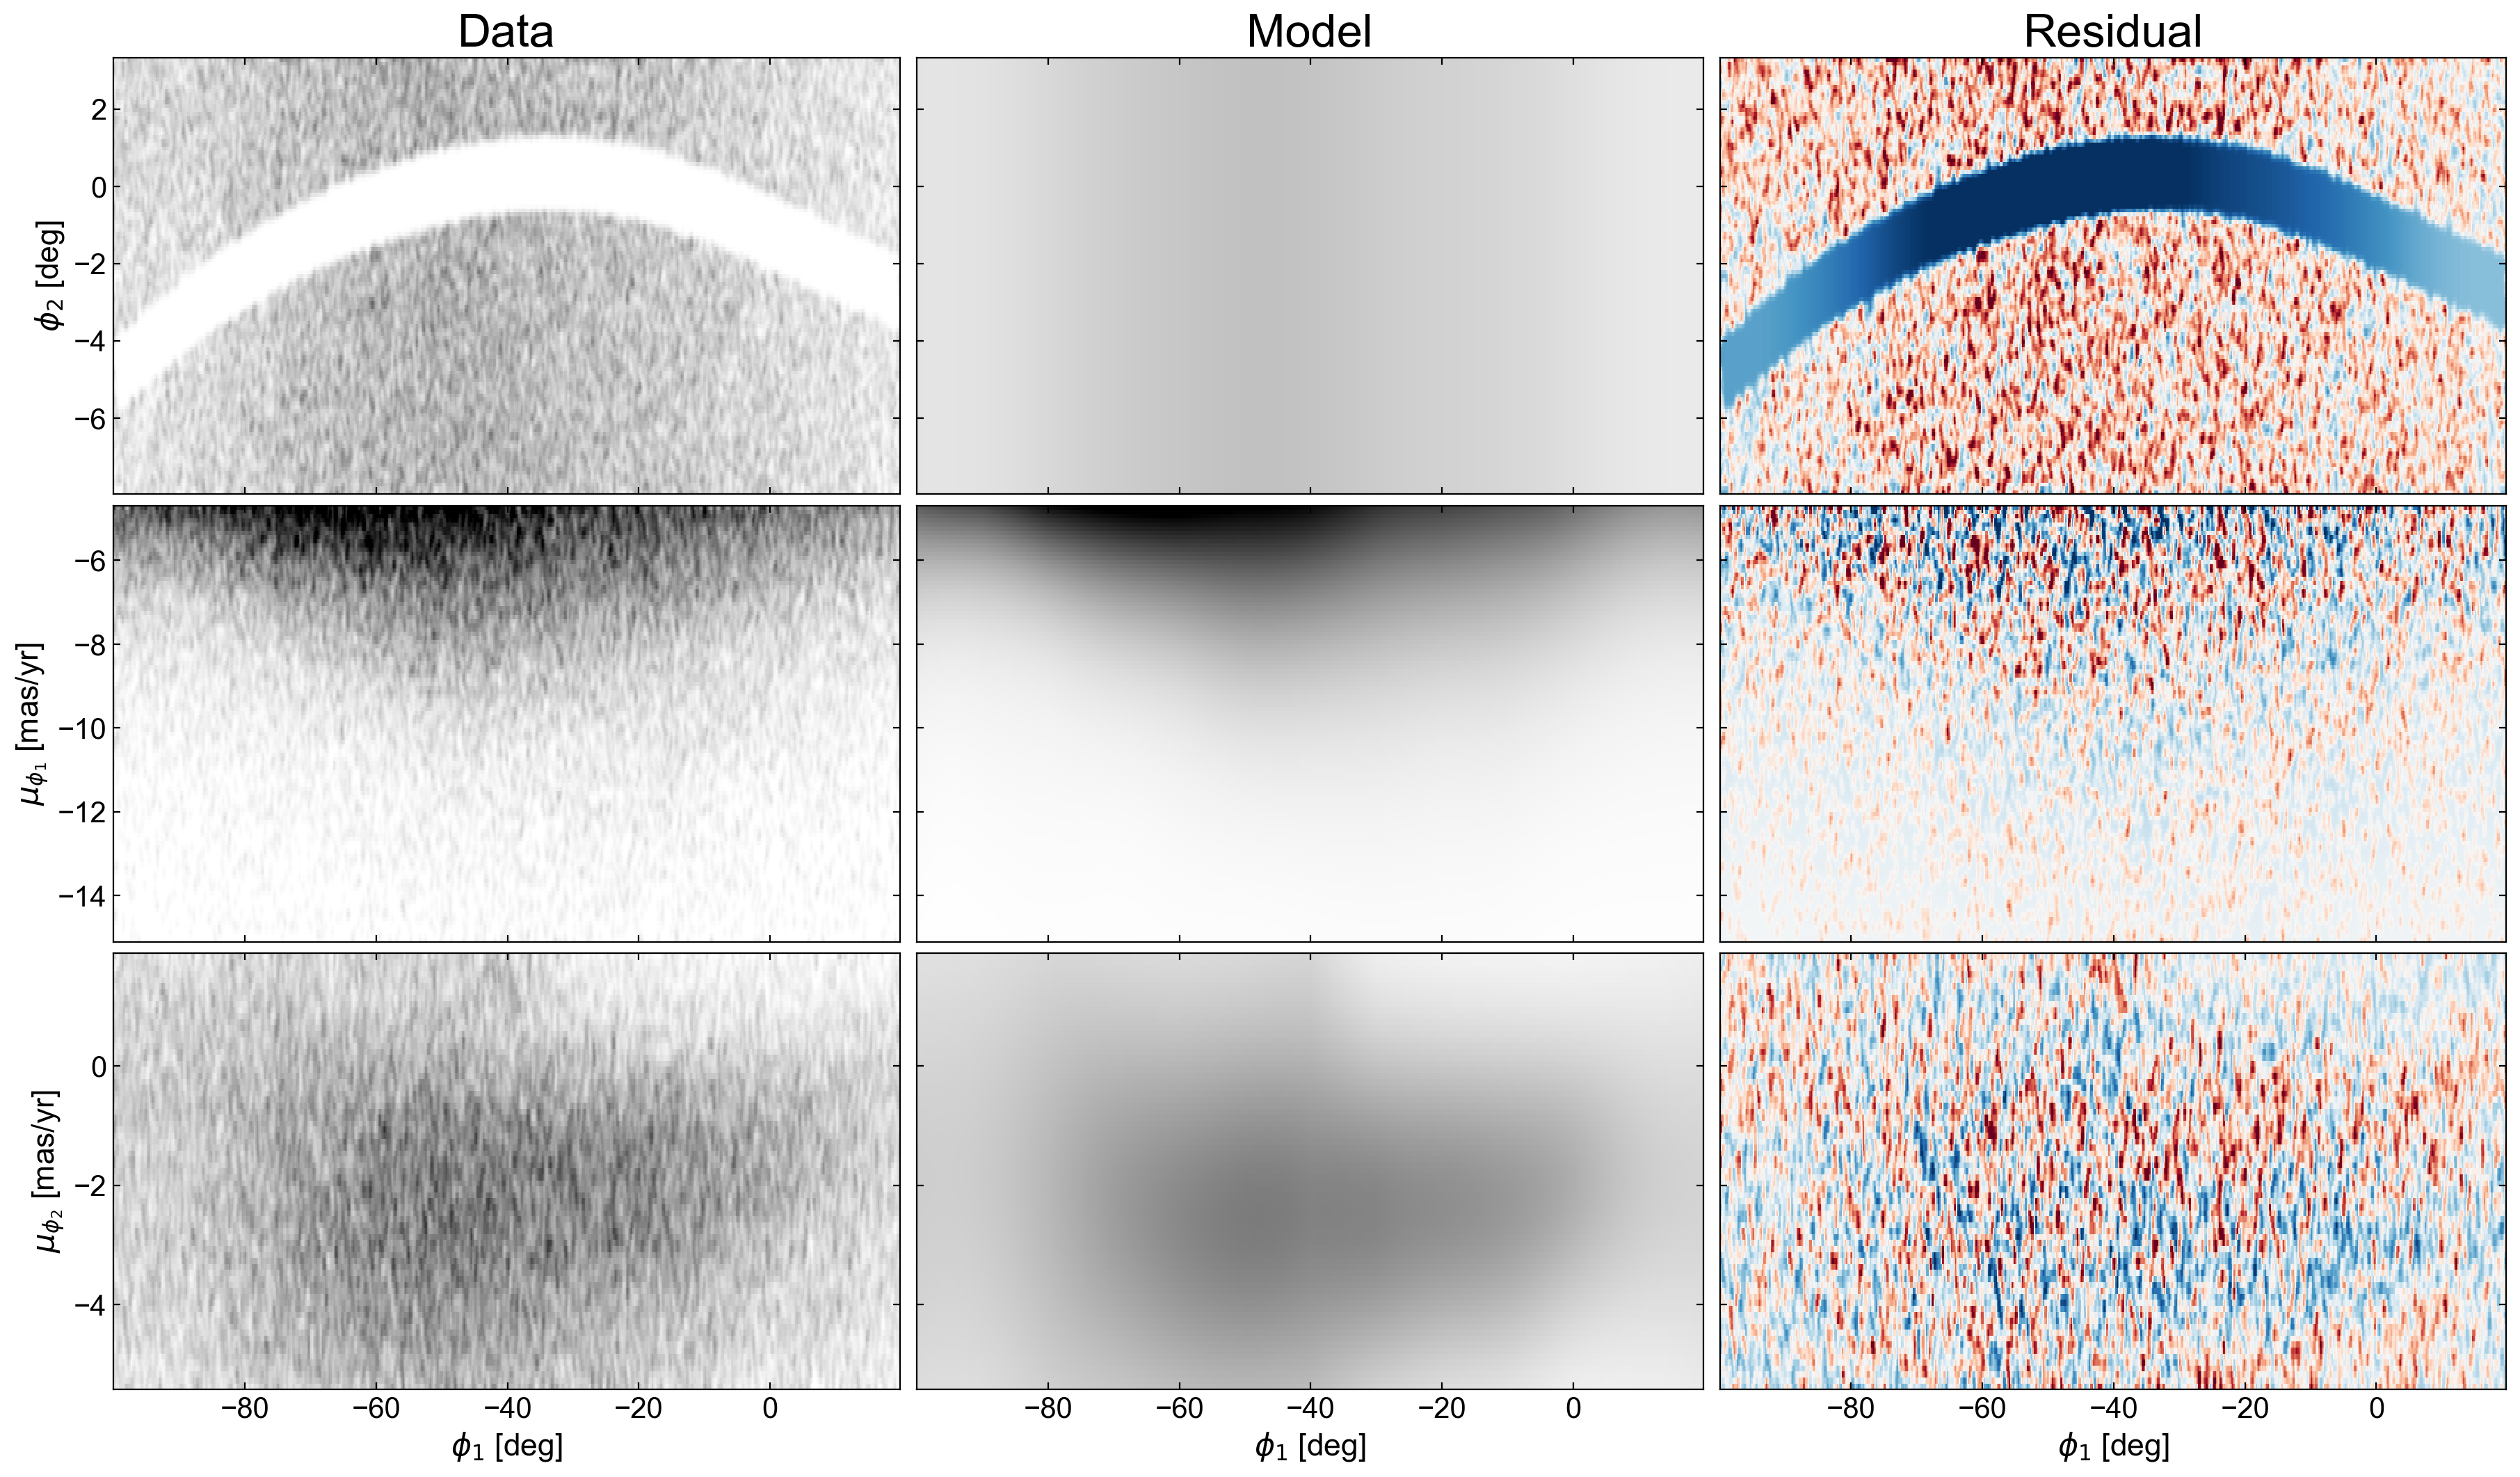

In [12]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0)
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0))
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()
# fig.savefig('../../paper_figures/background_model.pdf')

# Stream

In [12]:
StrModel = make_stream_model(StreamDensModel, p, cat, knot_sep=10)

In [13]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 21))
_phi2_interp = IUS(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic, ext=0, k=1
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm1_interp = IUS(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=0, k=1
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm2_interp = IUS(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=0, k=1
)

In [14]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(StreamDensModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(StreamDensModel.phi2_knots),
        "ln_std": np.full_like(StreamDensModel.phi2_knots, np.log(inputs[stream]['width']/2))
    },
    "pm1": {
        "mean": _pm1_interp(StreamDensModel.pm1_knots),
        "ln_std": np.full_like(StreamDensModel.pm1_knots, -0.5)
    },
    "pm2": {
        "mean": _pm2_interp(StreamDensModel.pm2_knots),
        "ln_std": np.full_like(StreamDensModel.pm2_knots, -0.5)
    }
}

stream_init = StrModel(stream_init_p)

### Stream Sampling

In [134]:
rng_key = jax.random.PRNGKey(42)

fn = jax.tree_util.Partial(StrModel._objective, data=stream_data)
warmup = blackjax.window_adaptation(
    blackjax.nuts,
    fn,
)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

In [136]:
%%time

(state, parameters), _ = warmup.run(
    warmup_key,
    stream_init_p,
    num_steps=1000
)

2024-06-28 09:31:05.164687: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-06-28 09:43:19.047437: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 14m13.89002s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


CPU times: user 18min 17s, sys: 22.5 s, total: 18min 39s
Wall time: 18min 42s


In [137]:
%%time

nuts = blackjax.nuts(fn, **parameters)
kernel = nuts.step
stream_states = inference_loop(sample_key, kernel, state, 10000)

stream_mcmc_samples = stream_states.position

2024-06-28 09:56:50.243088: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-06-28 10:11:44.659468: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 16m54.42518s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


CPU times: user 14min 7s, sys: 35.1 s, total: 14min 42s
Wall time: 22min 31s


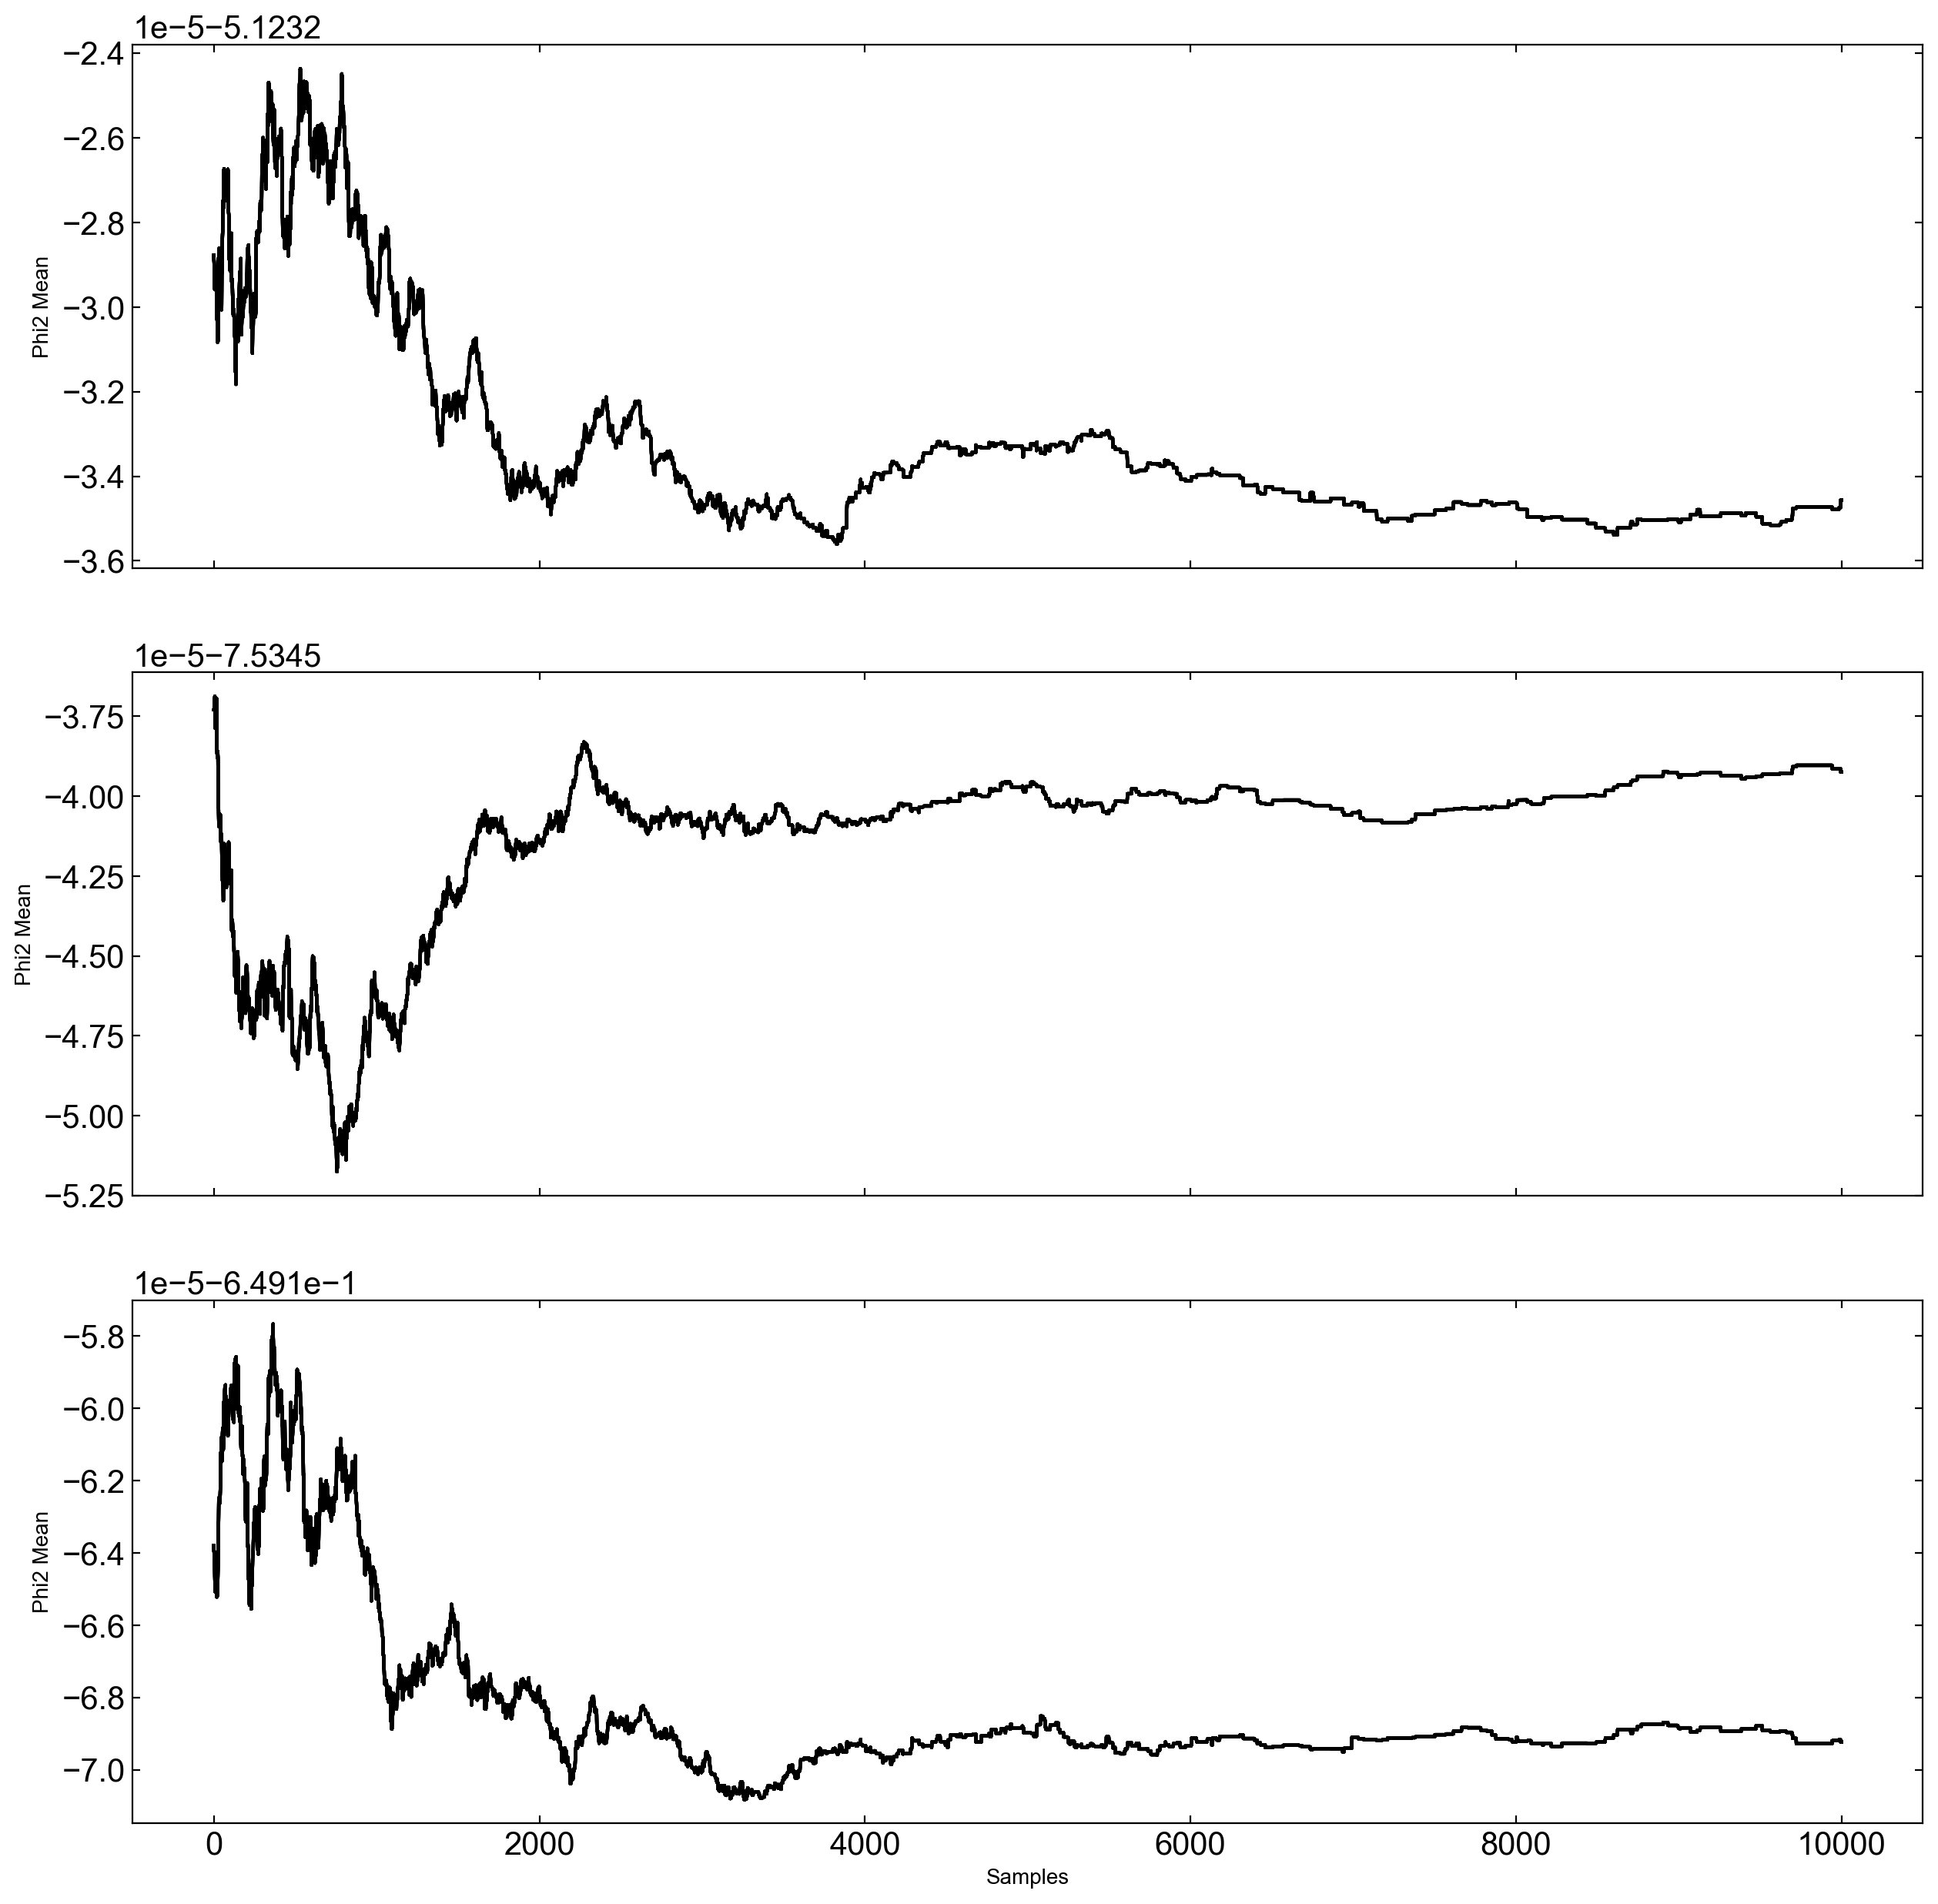

In [215]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15, 15), sharex=True)
for i in range(stream_mcmc_samples["phi2"]['mean'].shape[-1])):
    ax1.plot(stream_mcmc_samples["phi2"]['mean'][:,i], c='k')
    ax2.plot(stream_mcmc_samples["pm1"]['mean'][:,i], c='k')
    ax3.plot(stream_mcmc_samples["pm2"]['mean'][:,i], c='k')

ax3.set_xlabel("Samples")
ax1.set_ylabel("Phi2 Mean")
ax2.set_ylabel("Phi2 Mean")
ax3.set_ylabel("Phi2 Mean")

ax1.set_ylim(-7, 5)
# ax2.set_ylim(-7, 5)
# ax3.set_ylim(-7, 5)

plt.show()

In [13]:
nuts_kernel = NUTS(StrModel.setup_numpyro)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, )
rng_key = jax.random.PRNGKey(0)

mcmc.run(rng_key, data=stream_data, init_params=stream_opt_pars)

### Variational Inference

In [16]:
rng_key = jax.random.PRNGKey(8675309)

guide = AutoNormal(model=StrModel.setup_numpyro)
optimizer = numpyro.optim.Adam(step_size=1e-2) #play with this
svi = SVI(StrModel.setup_numpyro, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = jax.random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    10_000,
    data=stream_data,
    init_params=stream_init_p
)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.88it/s, init loss: 20220551.7728, avg. loss [9501-10000]: -522.3230]


In [17]:
params = svi_result.params
posterior_samples = guide.sample_posterior(jax.random.PRNGKey(1), params, sample_shape=(10000,))

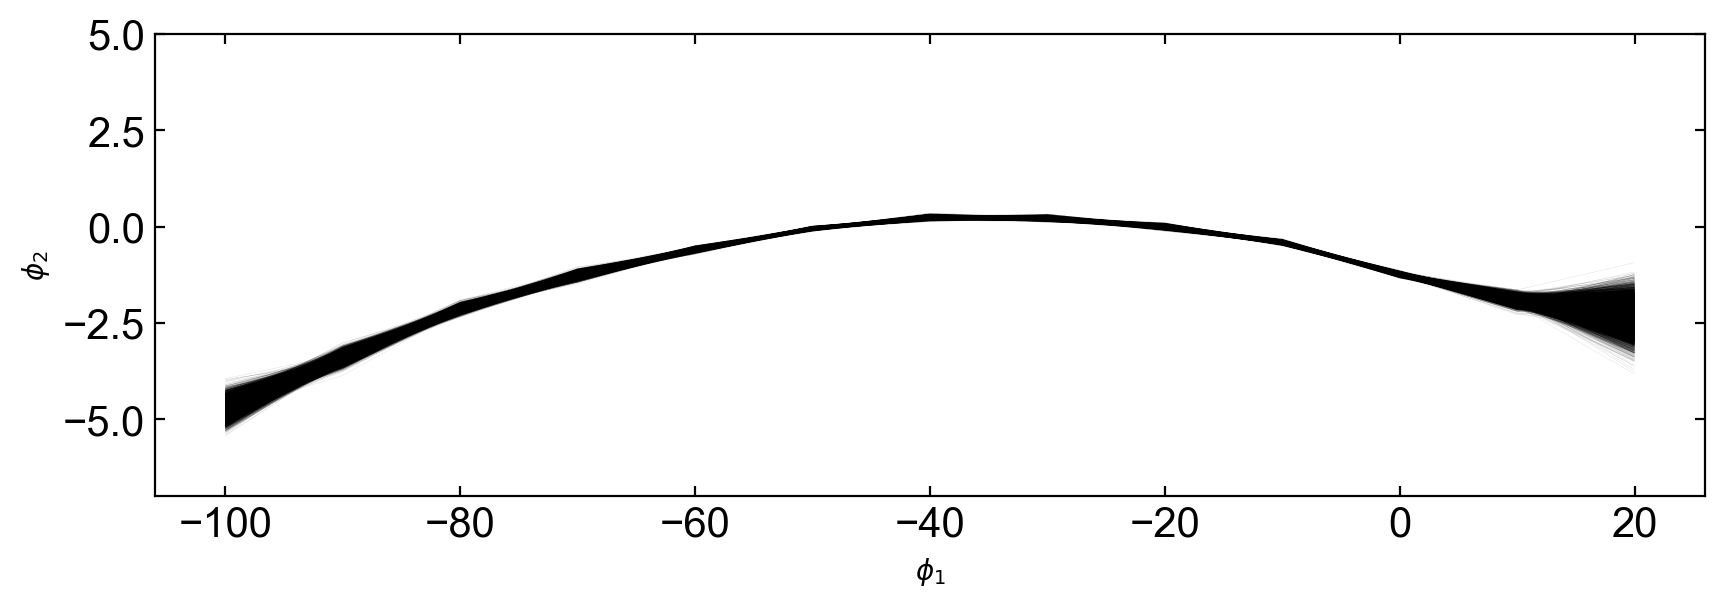

In [18]:
plt.figure(figsize=(10,3))
plt.plot(np.repeat(StrModel.phi2_knots.reshape(1,13), 10000, axis=0).T, posterior_samples['stream-phi2-mean'].T, 
         c='k', lw=0.1, alpha=0.2)
plt.ylim(-7, 5)
plt.xlabel(r'$\phi_1$') ; plt.ylabel(r'$\phi_2$')
plt.show()

### Stream Optimization

In [15]:
stream_opt_pars, info = stream_init.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True, jaxopt_kwargs=dict(maxiter=4096),
)

stream_opt = StrModel(stream_opt_pars)
info

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.009671128100692872 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.009671128100692872 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 21.82352957050671 Stepsize:1.0  Decrease Error:3.9719794354172424  Curvature Error:21.82352957050671 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.22457571470165588  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.33686357205248385  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.5052953580787258  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.7579430371180887  Decrease Error:0.0  

LbfgsbState(iter_num=Array(94, dtype=int64, weak_type=True), value=Array(-0.66561482, dtype=float64), grad={'ln_N': Array(-2.99760217e-15, dtype=float64), 'phi1': {'zs': Array([ 3.55679028e-05,  7.25557809e-05,  2.95759794e-04,  4.37320063e-04,
        8.91074564e-05, -2.71540853e-04, -6.39073358e-04, -7.64690105e-05,
        2.28631607e-04,  7.16680566e-05,  1.69178441e-05, -9.60130398e-05,
        3.88366813e-04,  6.50262521e-04, -2.86224198e-04, -1.52808842e-04,
       -1.78709409e-04, -1.59793946e-04,  1.73690012e-04,  7.29822609e-04,
        7.49958038e-05,  4.00370250e-05,  1.28939141e-04, -5.31291409e-04,
        1.66426284e-05,  4.98358405e-06, -3.60951626e-04,  1.85552546e-04,
        2.96059831e-04, -9.73152626e-05, -1.50415187e-04, -4.65599427e-05],      dtype=float64)}, 'phi2': {'ln_std': Array([ 4.43093351e-04,  4.05585190e-05, -5.62887741e-05, -1.70429835e-05,
       -5.56446427e-04, -8.11554880e-05, -5.16307016e-04, -4.73944110e-06,
        1.68845460e-04,  9.65861995e-0

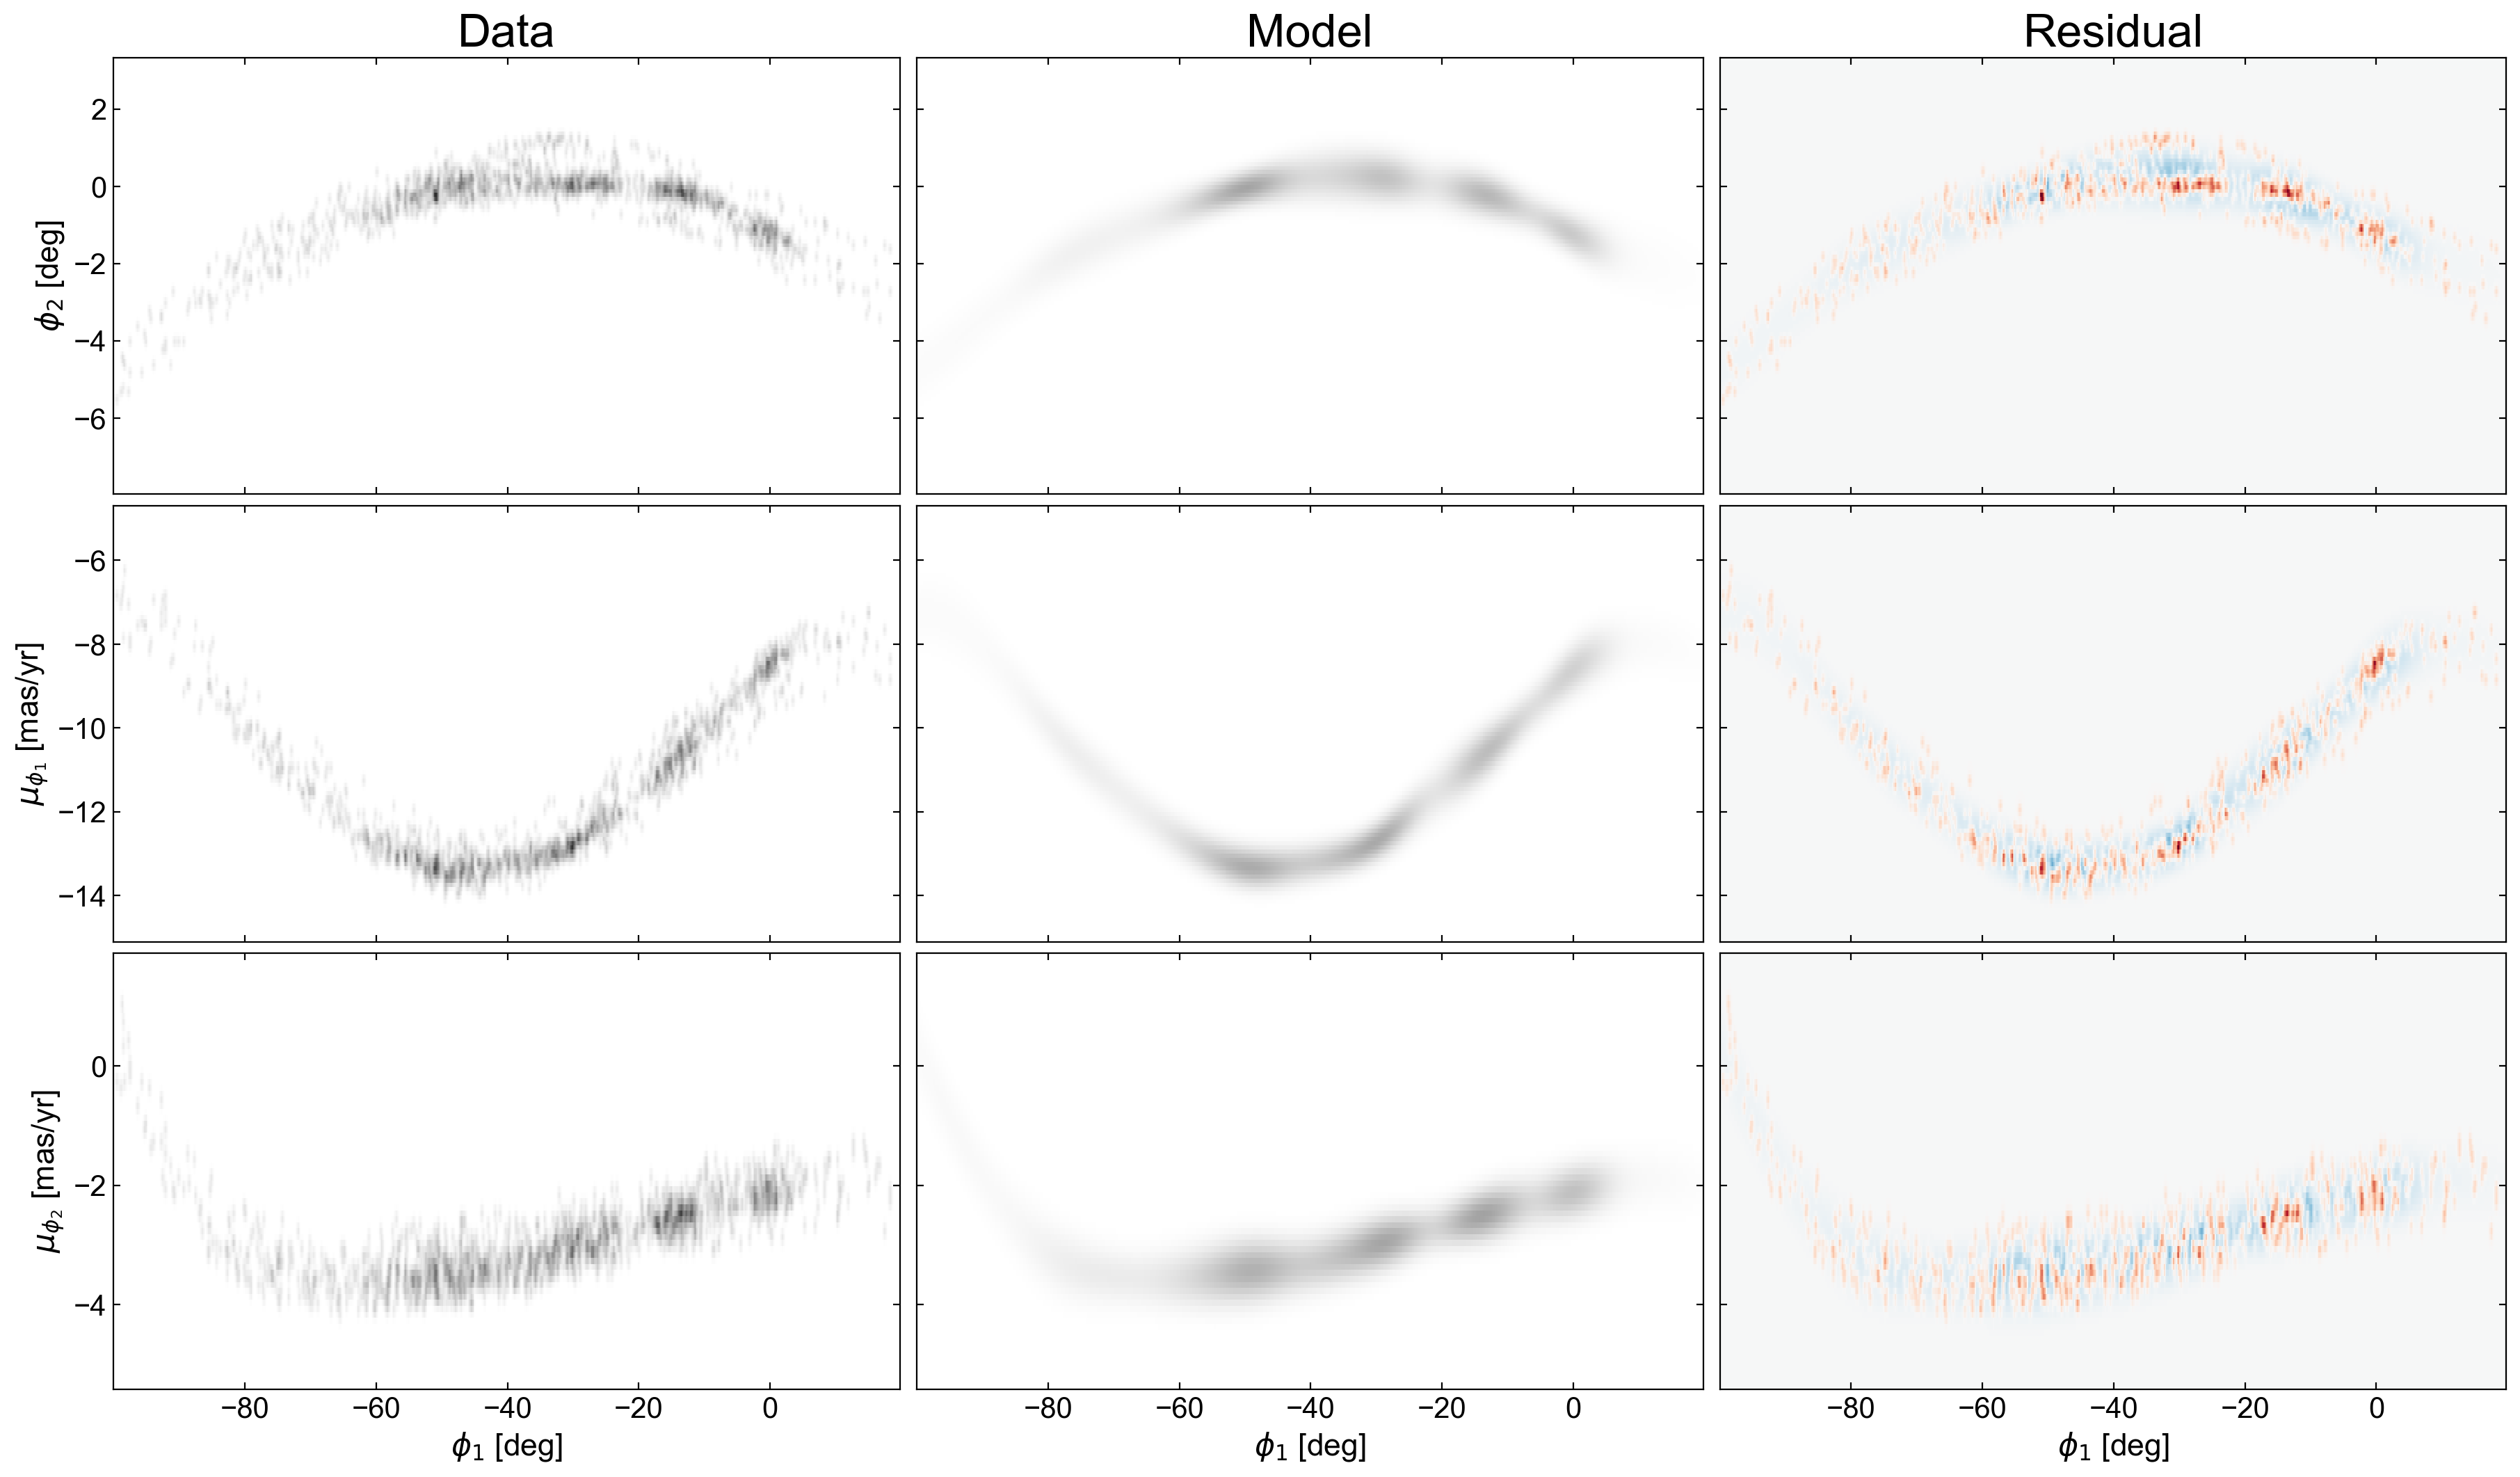

In [20]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=stream_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=2)
)
stream_opt.plot_model_projections(axes=axes[:, 1], label=False, 
                                  pcolormesh_kwargs=dict(rasterized=True,vmin=0, vmax=2))
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()
# fig.savefig('../paper_figures/stream_model.pdf')

# Mixture of Stream + Background (no off-track)

In [16]:
Components = [StrModel, BkgModel]
MixModel_NoOff = make_mixture_model(StreamMixtureModel, Components)

In [17]:
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}
mix_params0['background']['ln_N'] = np.log(len(run_data['phi1']) - np.exp(mix_params0['stream']['ln_N']))

mix_init = MixModel_NoOff(mix_params0)

In [18]:
mix_opt_pars, info = MixModel_NoOff.optimize(
    data=run_data, init_params=mix_params0, use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096)
)

mix_opt = MixModel_NoOff(mix_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(0.68590468, dtype=float64, weak_type=True), success=True, status=0, iter_num=2286, hess_inv=LbfgsInvHessProduct(sk=[[-1.92875588e-05 -8.06520115e-04  4.32564049e-04 ...  3.30818644e-05
   1.87104998e-05  6.76200702e-04]
 [ 7.52700161e-05 -6.95454344e-04  2.28561754e-04 ...  1.16936272e-05
  -1.55304437e-05  5.94166297e-04]
 [-5.38569381e-05 -6.37870462e-04  3.10327969e-04 ...  1.01236823e-05
  -1.11733244e-05  4.70015102e-04]
 ...
 [-4.55195438e-05 -8.16775118e-04  4.73690981e-05 ...  1.94882032e-05
  -4.08214467e-06  8.19278610e-04]
 [-6.93124492e-05 -1.00389060e-03  2.57736658e-04 ...  3.28853996e-05
   3.58927179e-06  9.71919686e-04]
 [-3.85650844e-05 -6.38114115e-04  3.16678556e-04 ...  3.04004469e-05
   2.07611371e-05  5.47446859e-04]], yk=[[-1.89467241e-05  5.07632081e-07  7.57263802e-06 ...  4.73098764e-07
   4.97967984e-07  8.58621447e-08]
 [ 7.41051542e-05  2.06761621e-07  2.92613669e-06 ...  9.14811678e-08
   2.45131981e-08  8.39606066e-08]
 [-

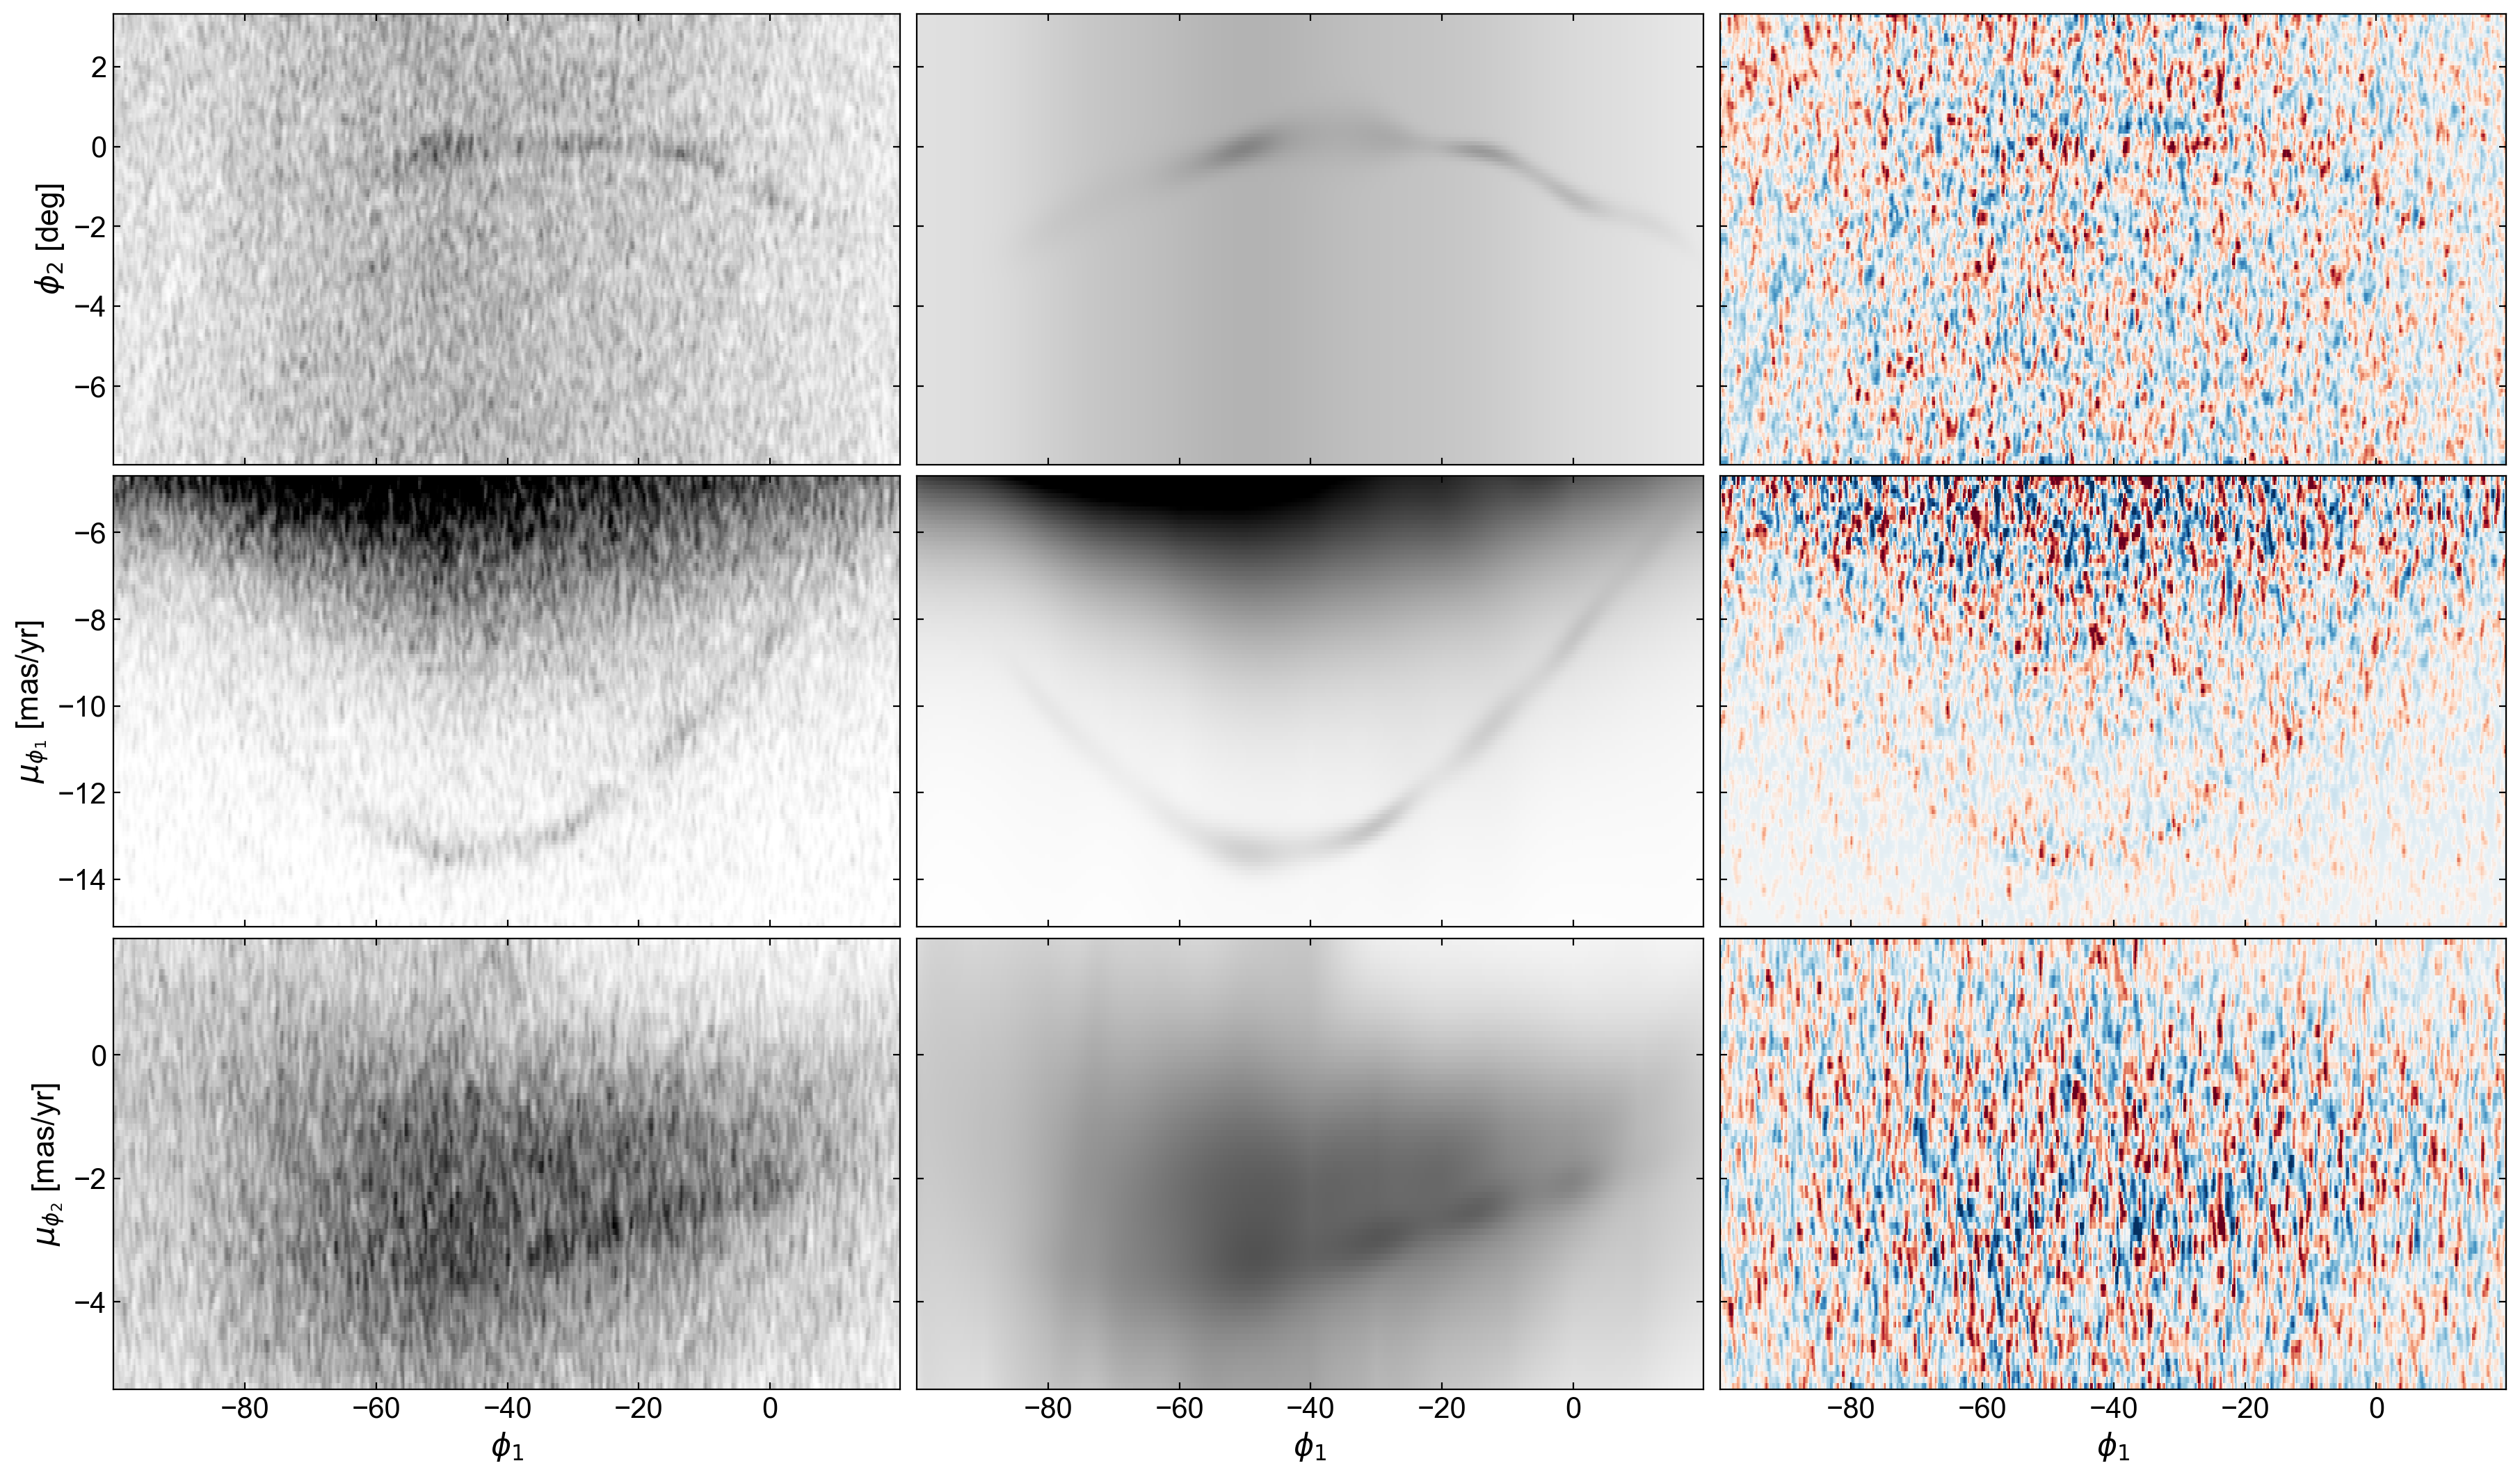

In [24]:
fig, axes = plt.subplots(
    len(mix_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(mix_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=mix_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=5)
)
mix_opt.plot_model_projections(axes=axes[:, 1], label=False,
                              pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=5))
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu')
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [46]:
with open('../data/mix_opt_params.pkl', 'wb') as output:
    pickle.dump(mix_opt_pars, output)

In [30]:
stream_comp, bkg_comp = mix_opt.components[0], mix_opt.components[1]
stream_ll = stream_comp.ln_number_density(run_data)
bkg_ll = bkg_comp.ln_number_density(run_data)
print(stream_ll.sum(), bkg_ll.sum())

-22396108.43720873 40446.19505393244


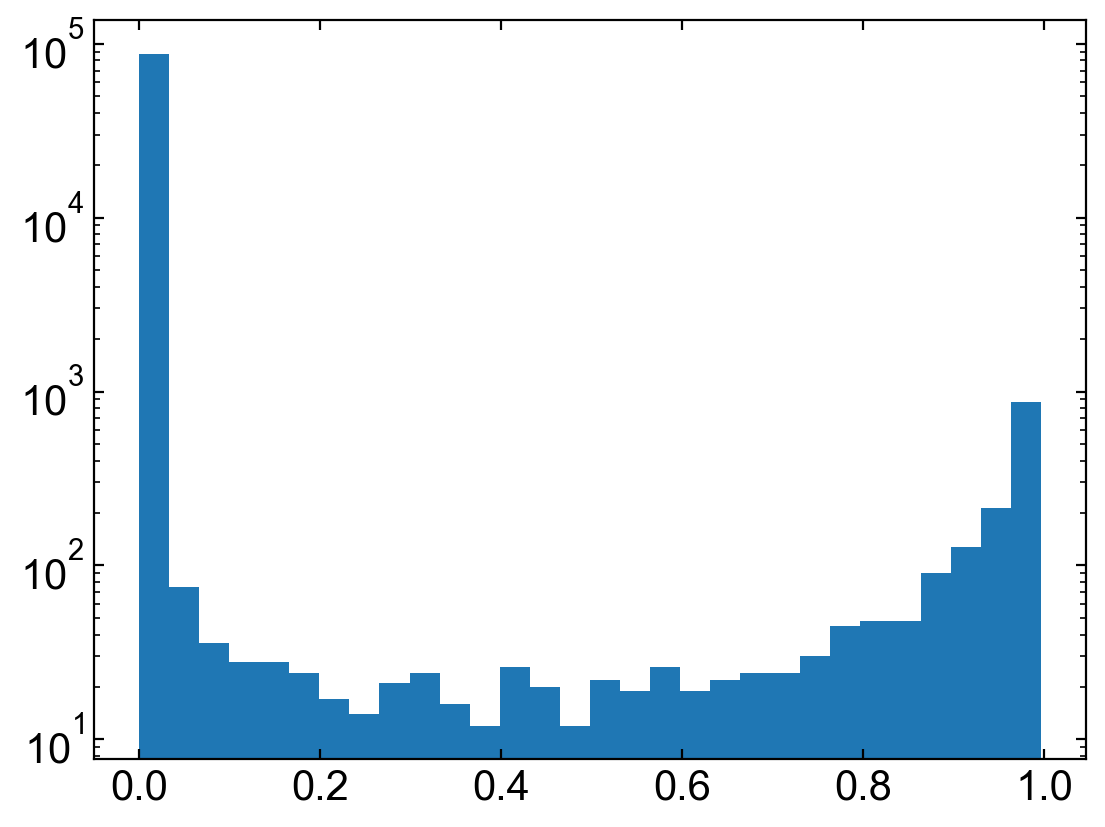

In [31]:
memb_prob = np.exp(stream_ll - np.logaddexp(stream_ll,bkg_ll))
plt.hist(memb_prob, bins=30)
plt.yscale('log')

In [32]:
(memb_prob > 0.5).sum()

1625

Text(0, 0.5, '$\\phi_2$')

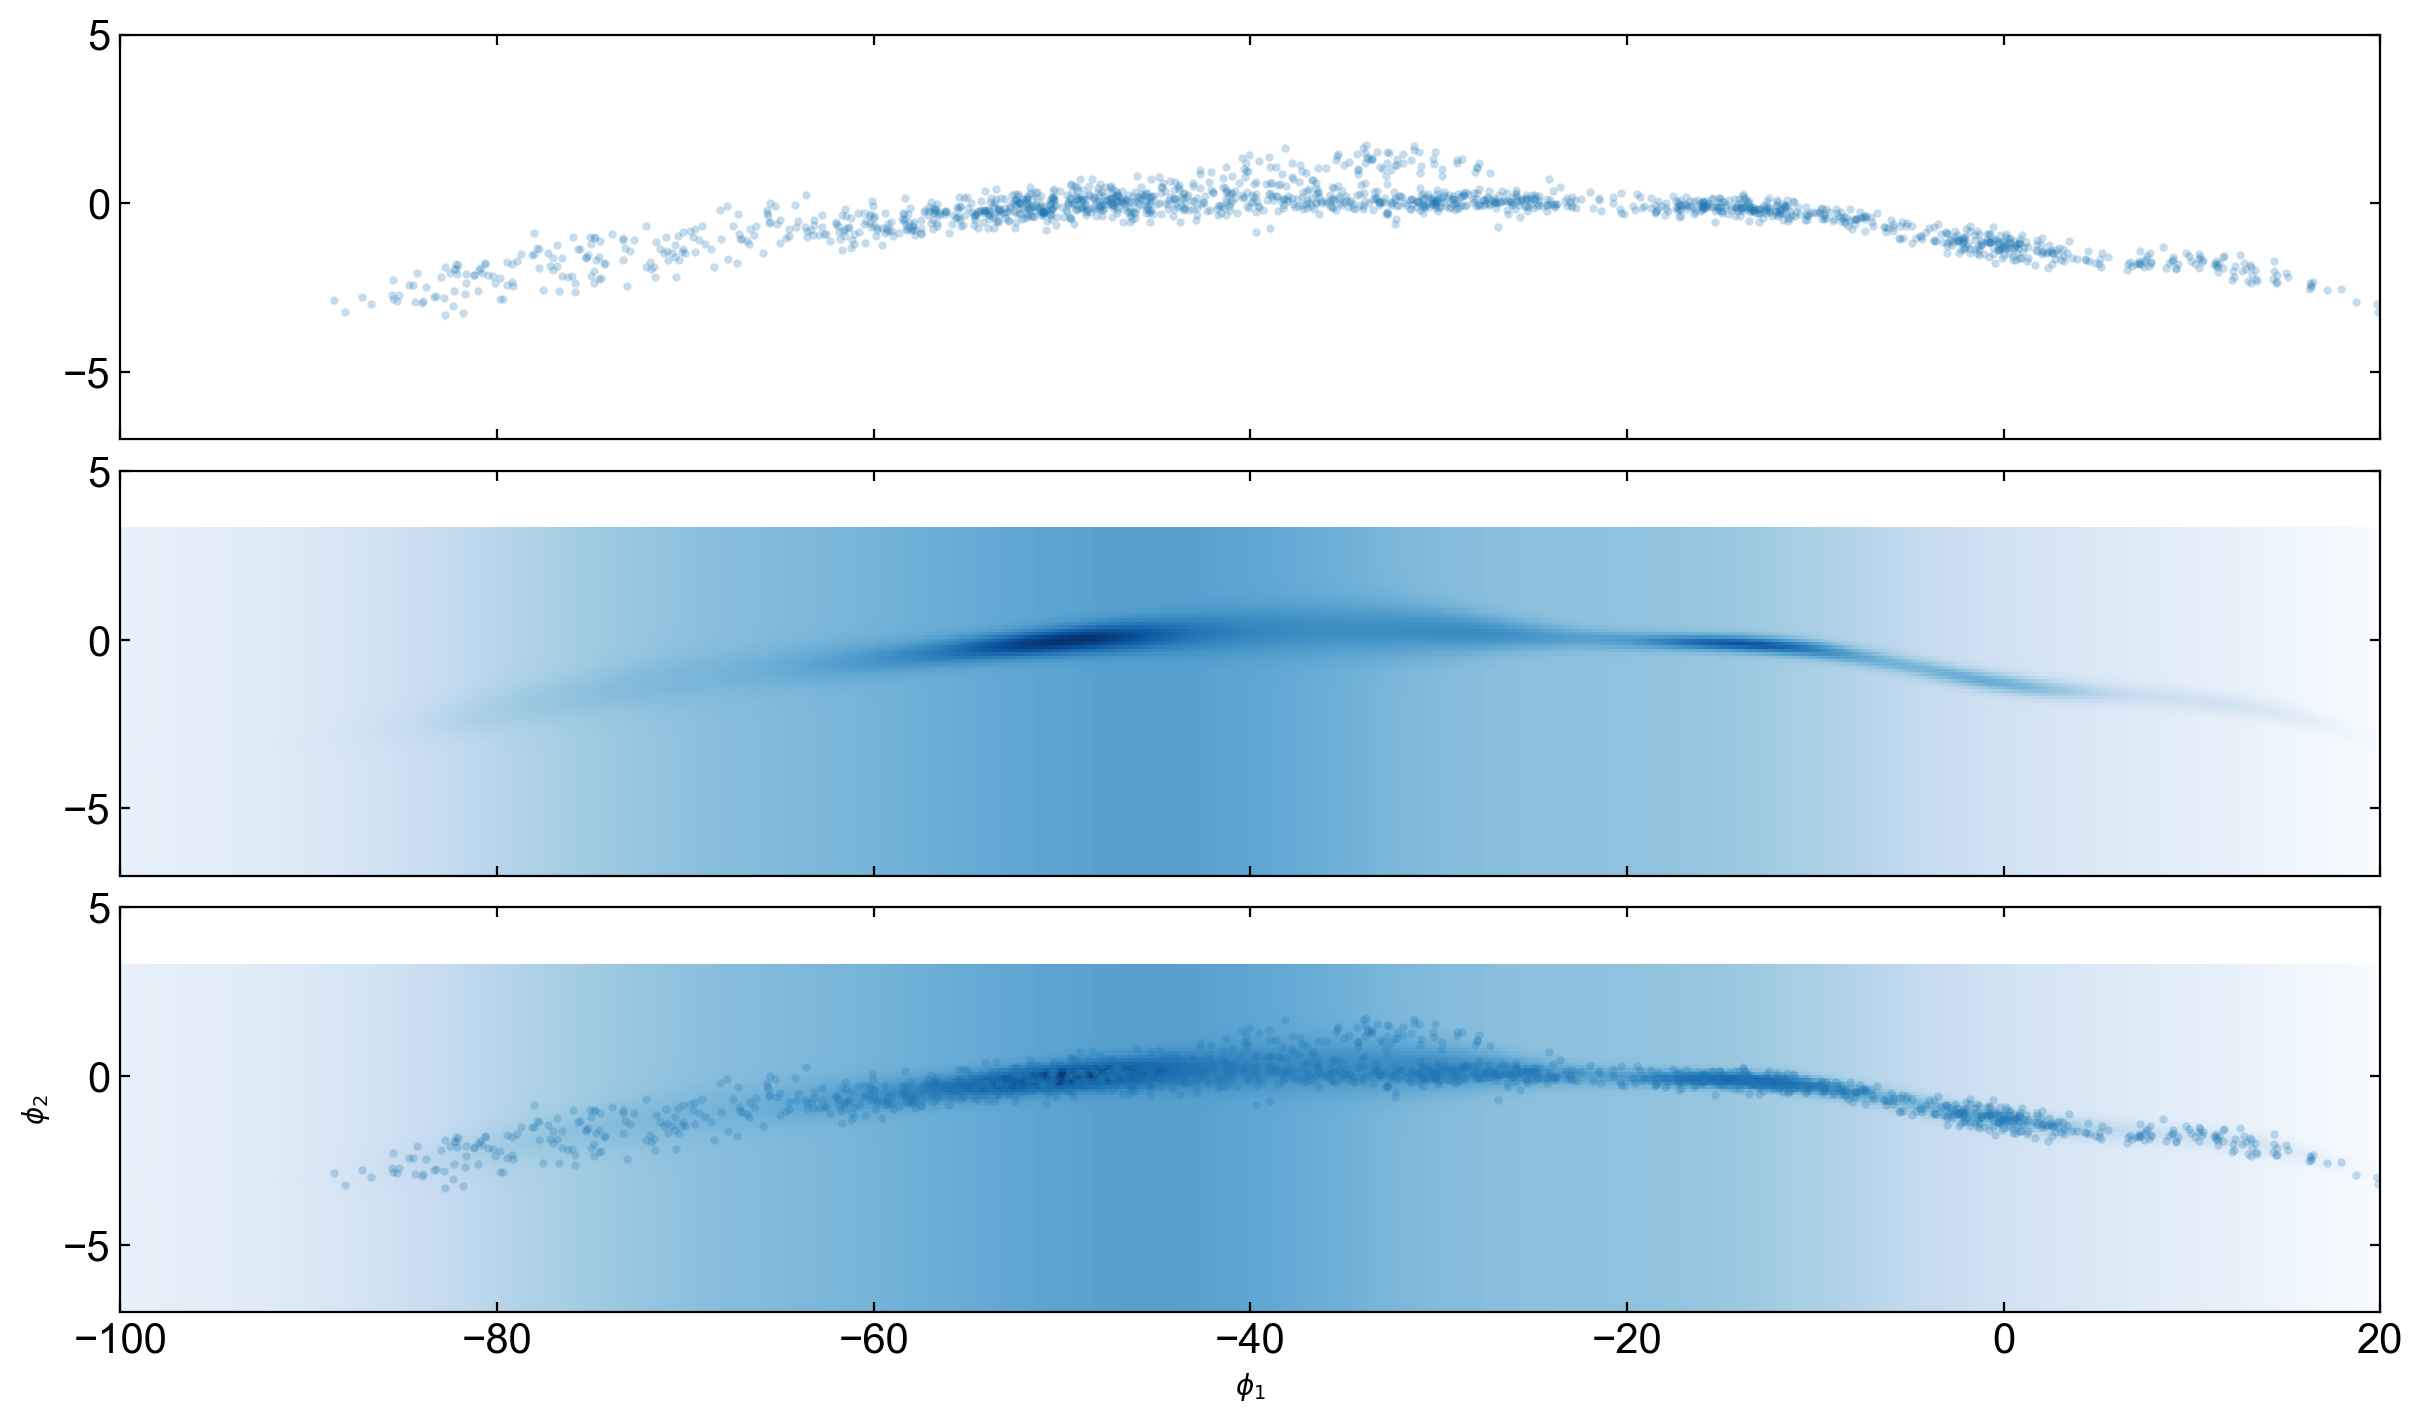

In [34]:
_grids, ln_dens = mix_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)
for ax in [axes[0], axes[2]]:
    ax.plot(
        run_data['phi1'][memb_prob>0.5],
        run_data['phi2'][memb_prob>0.5],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

# Off-track

In [19]:
OffModel = make_offtrack_model(OffTrackModel, p, cat, dens_steps=np.array([3,0.3]))

In [130]:
# OffModel.phi12_locs = OffModel.phi12_locs[np.abs(OffModel.phi12_locs[:,1] - _phi2_interp(OffModel.phi12_locs[:,0])) < 2]
# OffModel.phi12_scales = (np.full_like(OffModel.phi12_locs, OffModel.dens_steps[0]))
# OffModel.phi12_scales[:, 1] = OffModel.dens_steps[1]

# OffModel.variables = {
#         ("phi1", "phi2"): GridGMMVariable(
#             param_priors={
#                 "zs": dist.Uniform(-8.0, 8.0).expand((OffModel.phi12_locs.shape[0] - 1,))
#                 #                 "zs": dist.TruncatedNormal(
#                 #                     loc=-8, scale=4.0, low=-8.0, high=8.0
#                 #                 ).expand((phi12_locs.shape[0] - 1,))
#             },
#             locs=OffModel.phi12_locs,
#             scales=OffModel.phi12_scales,
#             coord_bounds=(
#                 np.array(
#                     [OffModel.coord_bounds["phi1"][0], OffModel.coord_bounds["phi2"][0]]
#                 ),
#                 np.array(
#                     [OffModel.coord_bounds["phi1"][1], OffModel.coord_bounds["phi2"][1]]
#                 ),
#             ),
#         ),
#         "pm1": StreamDensModel.variables["pm1"],
#         "pm2": StreamDensModel.variables["pm2"],
#     }

In [20]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

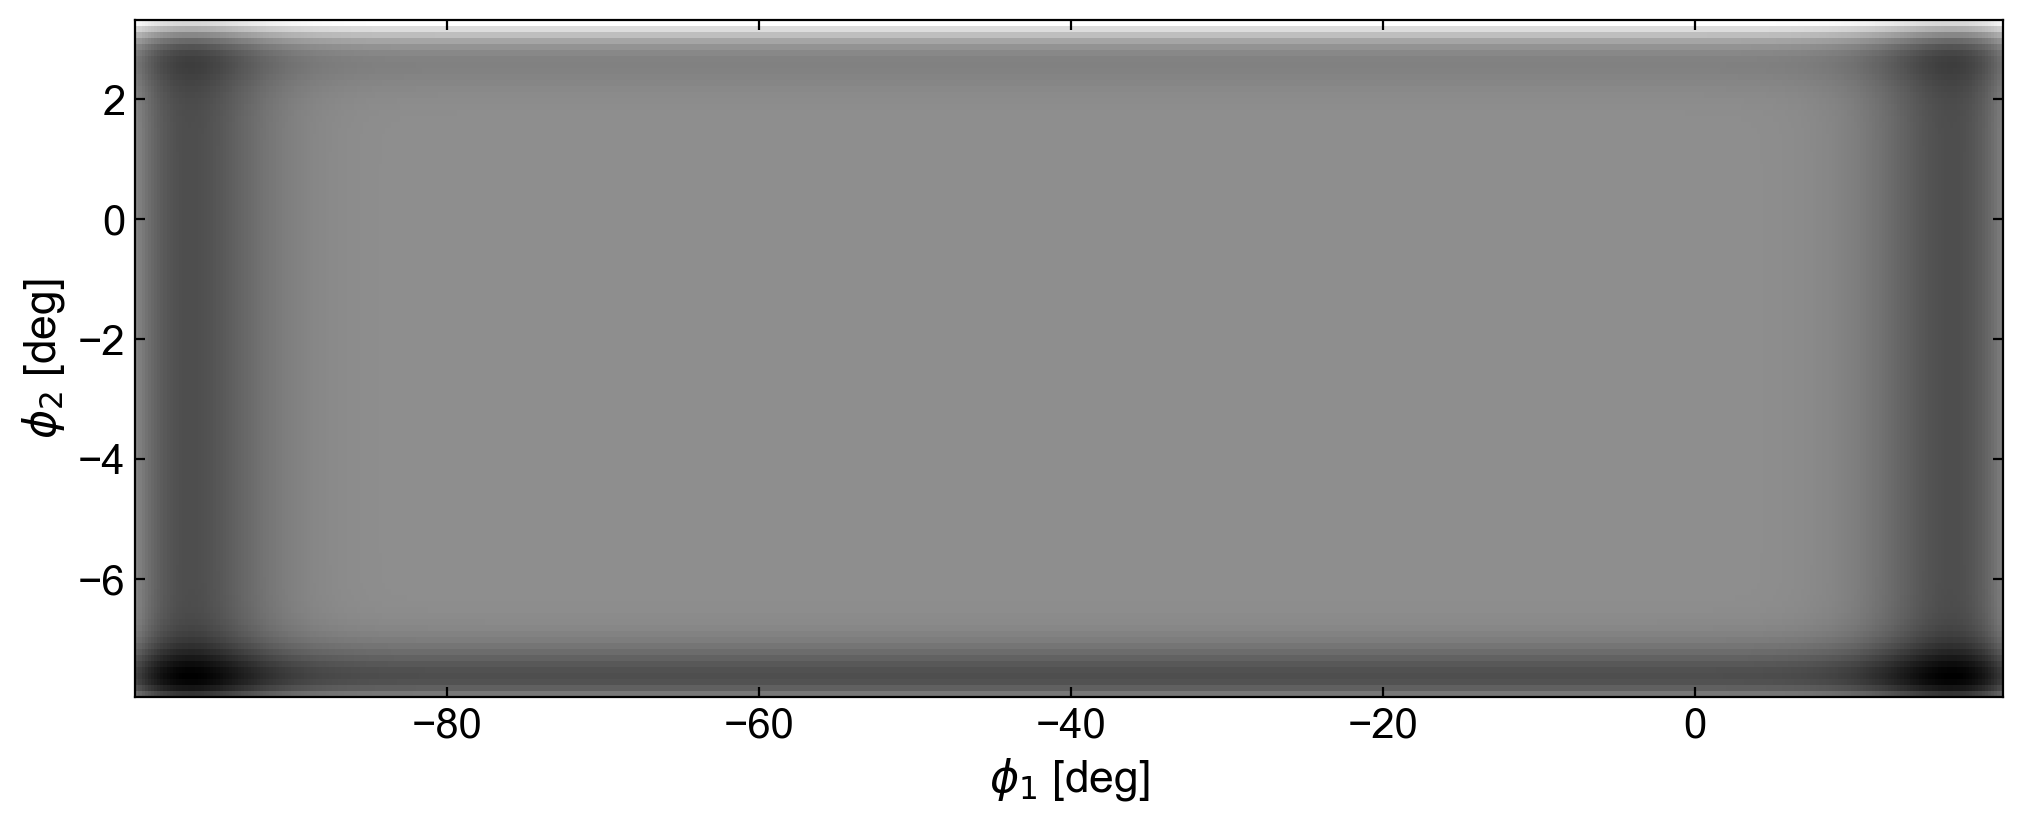

In [104]:
offtrack_init = OffModel(offtrack_init_p)
_ = offtrack_init.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [21]:
full_Components = [StrModel, BkgModel, OffModel]
full_mix_params0 = {
    "stream": mix_opt_pars['stream'],
    "background": mix_opt_pars['background'],
    "offtrack": offtrack_init_p,
}

MixModel = make_mixture_model(StreamMixtureModel, full_Components)

In [22]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = MixModel(
    full_mix_params0, tied_params=tied_params
)

### Variational Inference

Try to run this on the work computer and if that doesn't work, might need the CCA or figure something else out

In [ ]:
%%time

rng_key = jax.random.PRNGKey(8675309)

guide = AutoNormal(model=MixModel.setup_numpyro)
optimizer = numpyro.optim.Adam(step_size=1e-1) #play with this
svi = SVI(MixModel.setup_numpyro, guide, optimizer, loss=Trace_ELBO())
rng_key, rng_subkey = jax.random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    10_000,
    data=run_data,
    init_params=full_mix_params0
)

In [ ]:
params = svi_result.params
posterior_samples = guide.sample_posterior(jax.random.PRNGKey(1), params, sample_shape=(10000,))

### Optimization

In [135]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=False,
)

# full_mix_opt_pars, info = optimize_mixture(StreamMixtureModel, data=run_data,
#                                       init_params=full_mix_params0, Components=full_Components,
#                                       use_bounds=True)

full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

ScipyMinimizeInfo(fun_val=Array(0.68283109, dtype=float64, weak_type=True), success=True, status=0, iter_num=1698, hess_inv=Array([[ 7.70323214e-01, -2.24984805e-01,  7.53707840e-03, ...,
         1.08021333e-02,  6.04020731e-03, -1.86282329e-01],
       [-2.24984805e-01,  2.14573960e+02, -5.91080327e+00, ...,
         7.37656049e-01, -3.49072467e+00,  2.09414137e+00],
       [ 7.53707840e-03, -5.91080327e+00,  6.04441362e+01, ...,
        -1.54108928e-01, -2.51117096e-01, -6.29152298e+00],
       ...,
       [ 1.08021333e-02,  7.37656049e-01, -1.54108928e-01, ...,
         4.03870429e+01, -5.17781842e+00,  2.52933878e+01],
       [ 6.04020731e-03, -3.49072467e+00, -2.51117096e-01, ...,
        -5.17781842e+00,  1.52901462e+02, -5.44660298e+01],
       [-1.86282329e-01,  2.09414137e+00, -6.29152298e+00, ...,
         2.52933878e+01, -5.44660298e+01,  2.48617233e+03]],      dtype=float64), num_fun_eval=Array(1702, dtype=int32), num_jac_eval=Array(1702, dtype=int32), num_hess_eval=Array(

In [128]:
with open('../../data/full_model_opt_params_tied_params_no_bounds.pkl', 'wb') as output_file2:
    pickle.dump(full_mix_opt_pars, output_file2)

In [172]:
# with open('../data/full_model_optimization.pkl', 'rb') as input_file:
#     testing1 = pickle.load(input_file)

with open('../data/full_model_opt_params_small_sep.pkl', 'rb') as input_file:
    full_mix_opt_pars = pickle.load(input_file)

In [47]:
# if optimization fails, run again with initialization from the end of the last run

# full_mix_params1 = full_mix_opt_pars

# full_mix_opt_pars1, info1 = StreamMixtureModel.optimize(
#     data=run_data,
#     Components=full_Components,
#     #tied_params=tied_params,
#     init_params=full_mix_params1,
#     use_bounds=True,
# )
# full_mix_opt1 = StreamMixtureModel(full_mix_opt_pars1, Components=full_Components)
# info1

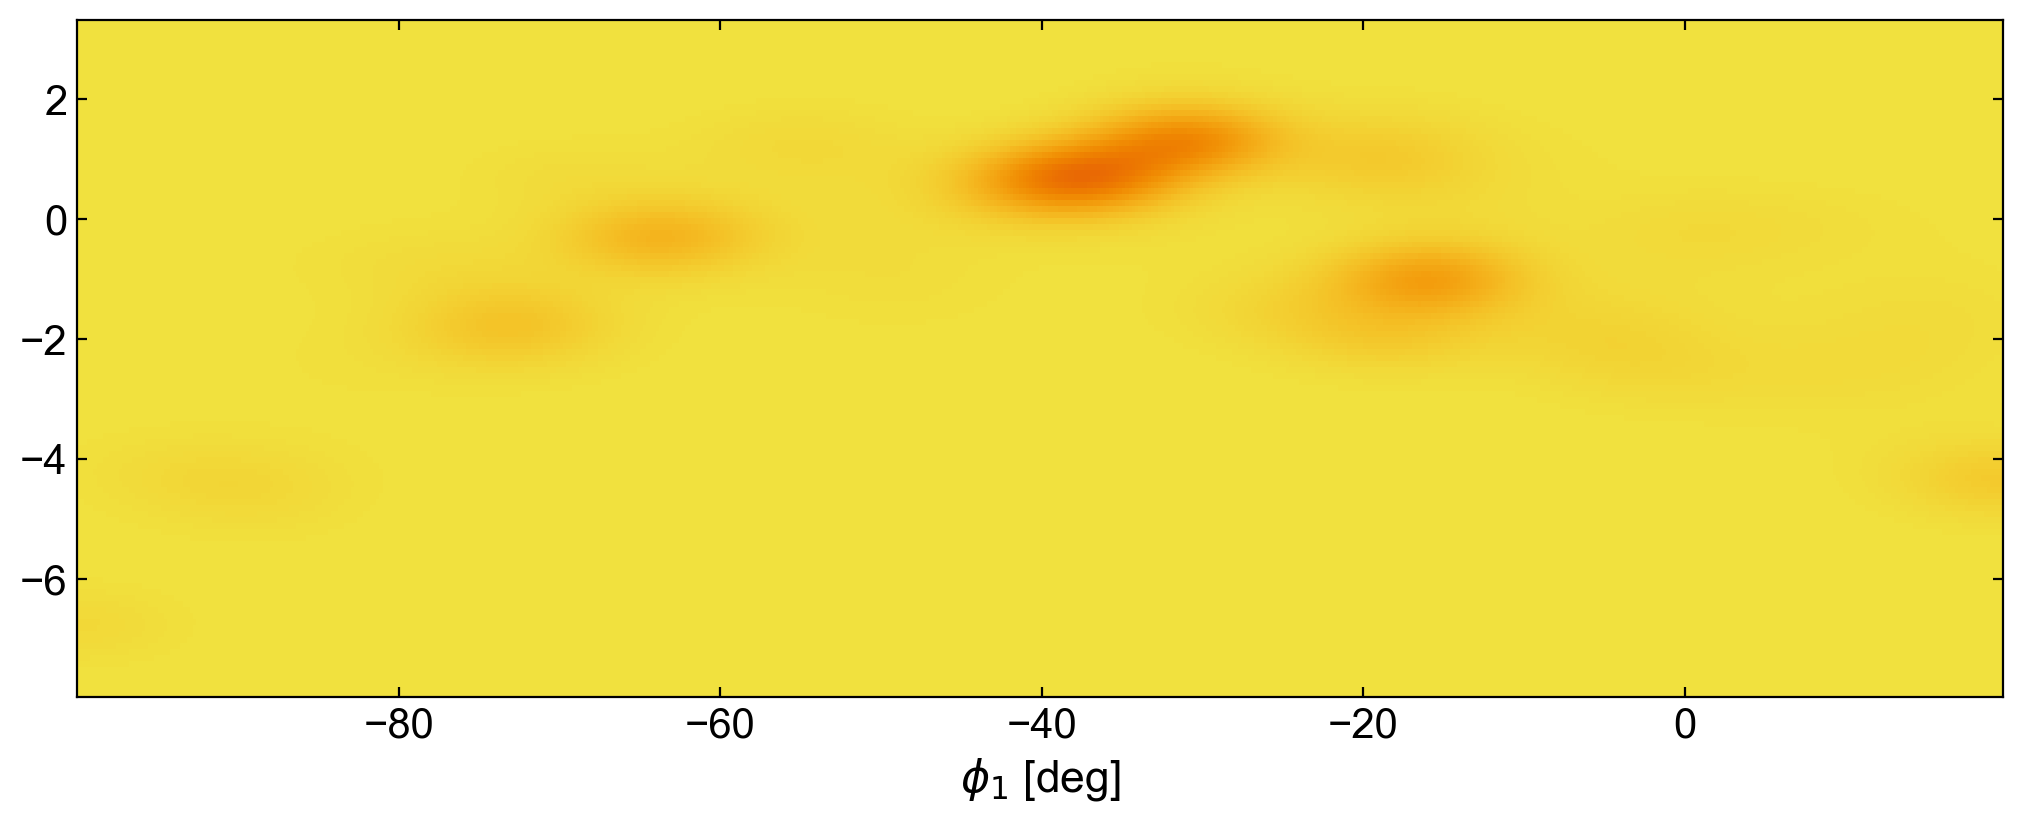

In [136]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = OffTrackModel(tmp_pars)
_,_,pcms = tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], label=False, 
    pcolormesh_kwargs=dict(vmin=0, vmax=0.5, cmap='cmr.ember_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$ [deg]', ylabel='$\\phi_2$ [deg]'>],
       dtype=object),
 [<matplotlib.collections.QuadMesh at 0x1cbf22390>])

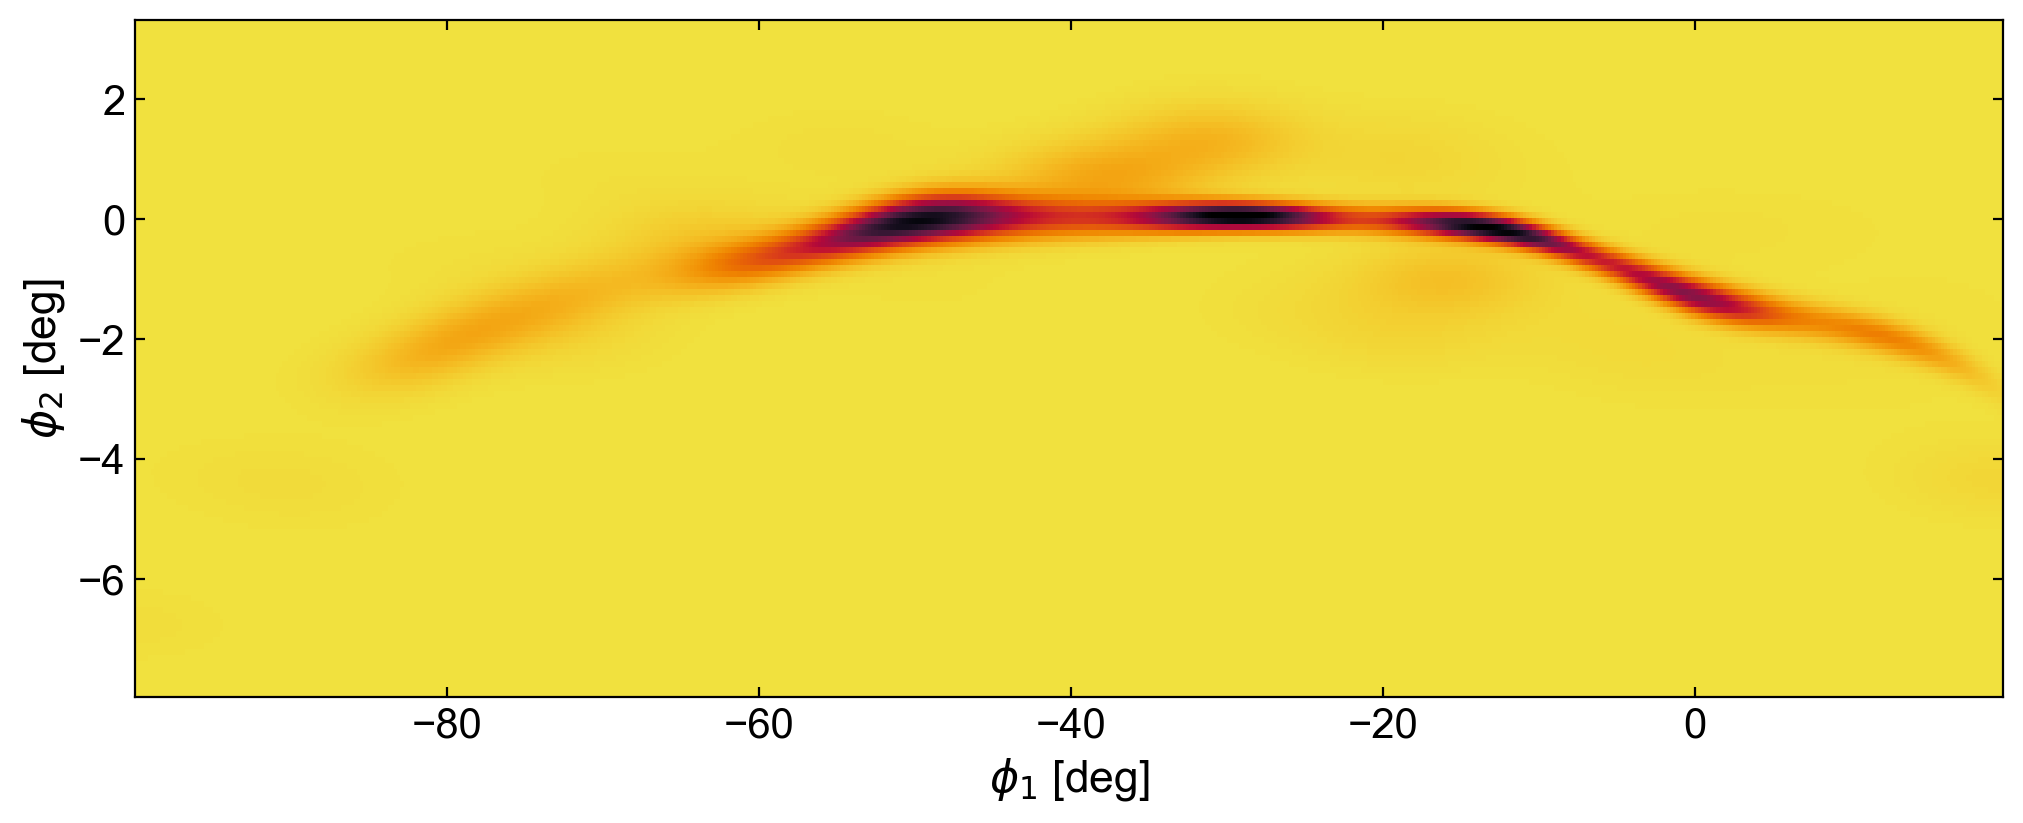

In [137]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[StreamDensModel, OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=1, cmap='cmr.ember_r')
)

In [96]:
full_mix_opt.components

In [102]:
stream_comp, bkg_comp, offtrack_comp = full_mix_opt.components[0], full_mix_opt.components[1], full_mix_opt.components[2]
stream_ll = stream_comp.ln_number_density(run_data)
bkg_ll = bkg_comp.ln_number_density(run_data)
offtrack_ll = offtrack_comp.ln_number_density(run_data)

#one way
fg_ll = np.logaddexp(stream_ll, offtrack_ll)

#another way
# fg_comps = full_mix_nobkg_opt.components
# fg_ll_ = -np.log(fg_comps[0].get_N() + fg_comps[1].get_N()) + full_mix_nobkg_opt.ln_number_density(run_data)

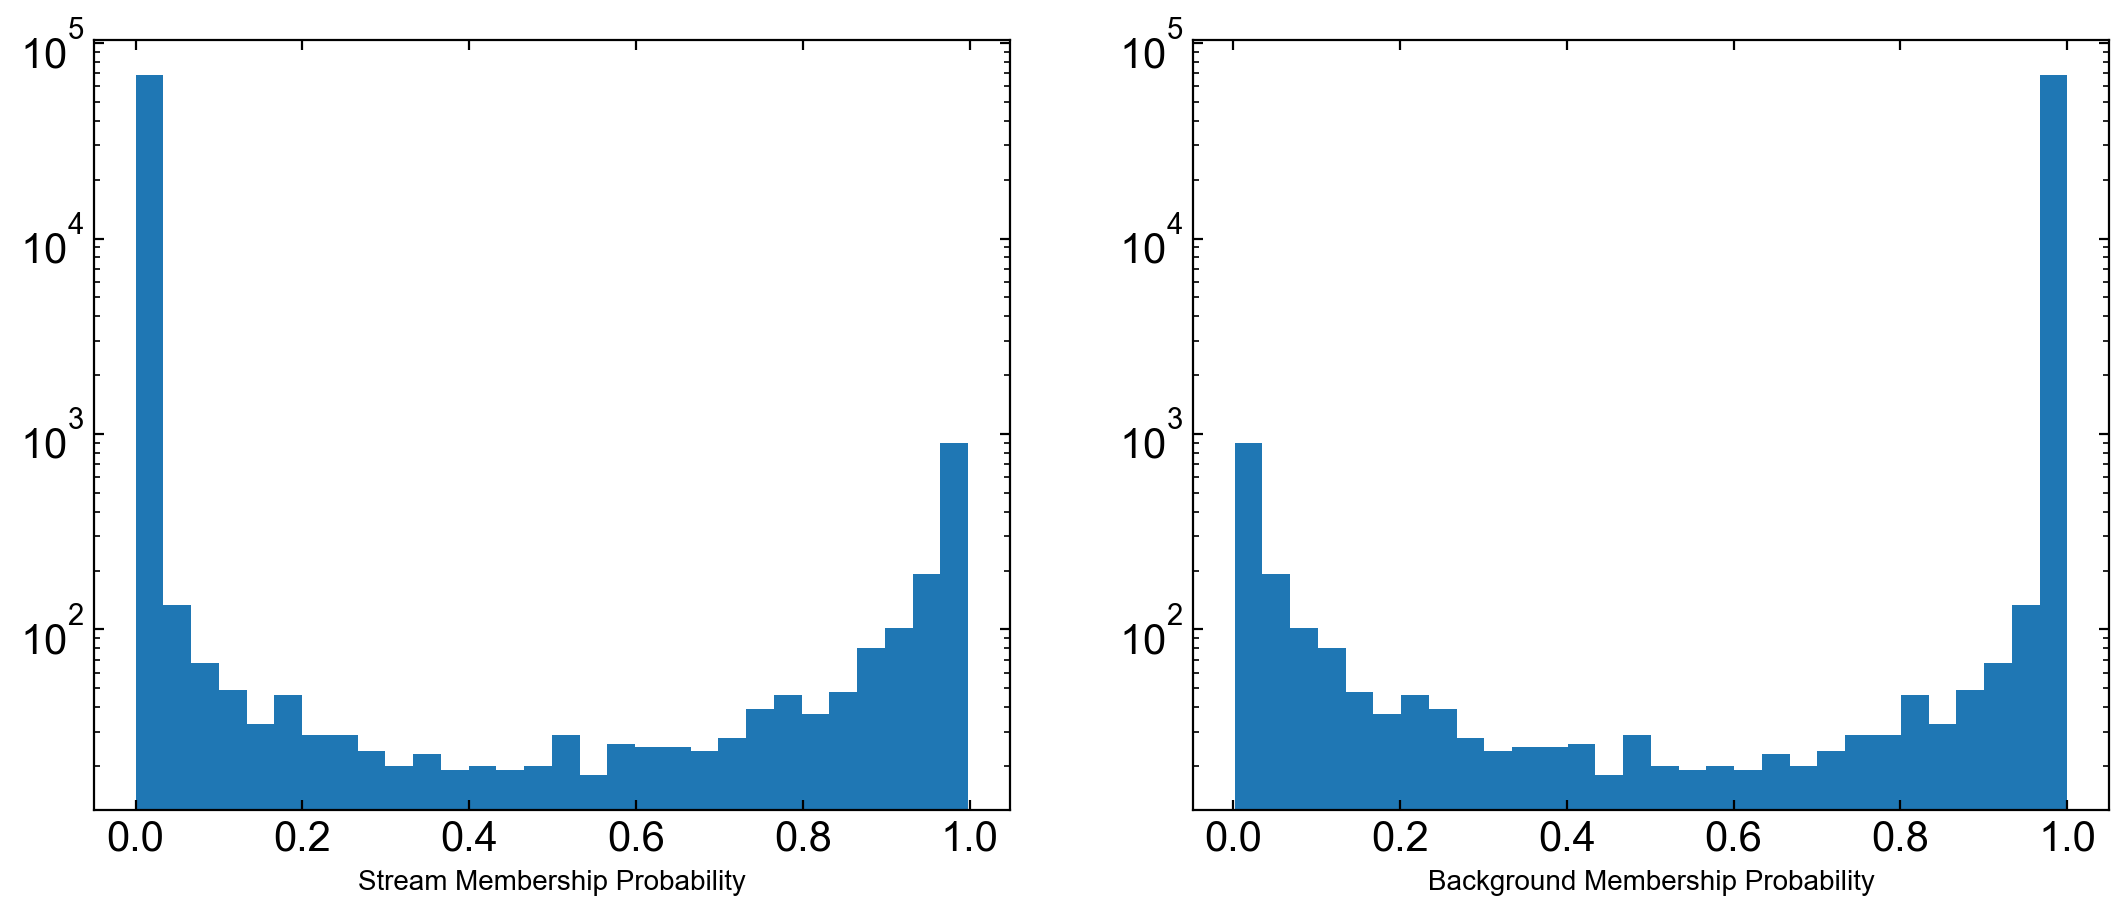

In [103]:
final_memb_prob = np.exp(fg_ll - np.logaddexp(fg_ll,bkg_ll)) #update for offtrack included
bkg_prob = np.exp(bkg_ll - np.logaddexp(fg_ll,bkg_ll))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.hist(final_memb_prob, bins=30)
ax1.set_yscale('log')
ax1.set_xlabel('Stream Membership Probability')

ax2.hist(bkg_prob, bins=30)
ax2.set_xlabel('Background Membership Probability')
ax2.set_yscale('log')
plt.show()

In [104]:
(final_memb_prob > 0.99).sum()

449

In [105]:
# for the plotting, but takes a minute, so have it in a differnet cell
_grids, ln_dens = full_mix_opt.evaluate_on_2d_grids()

Text(0, 0.5, '$\\phi_2$')

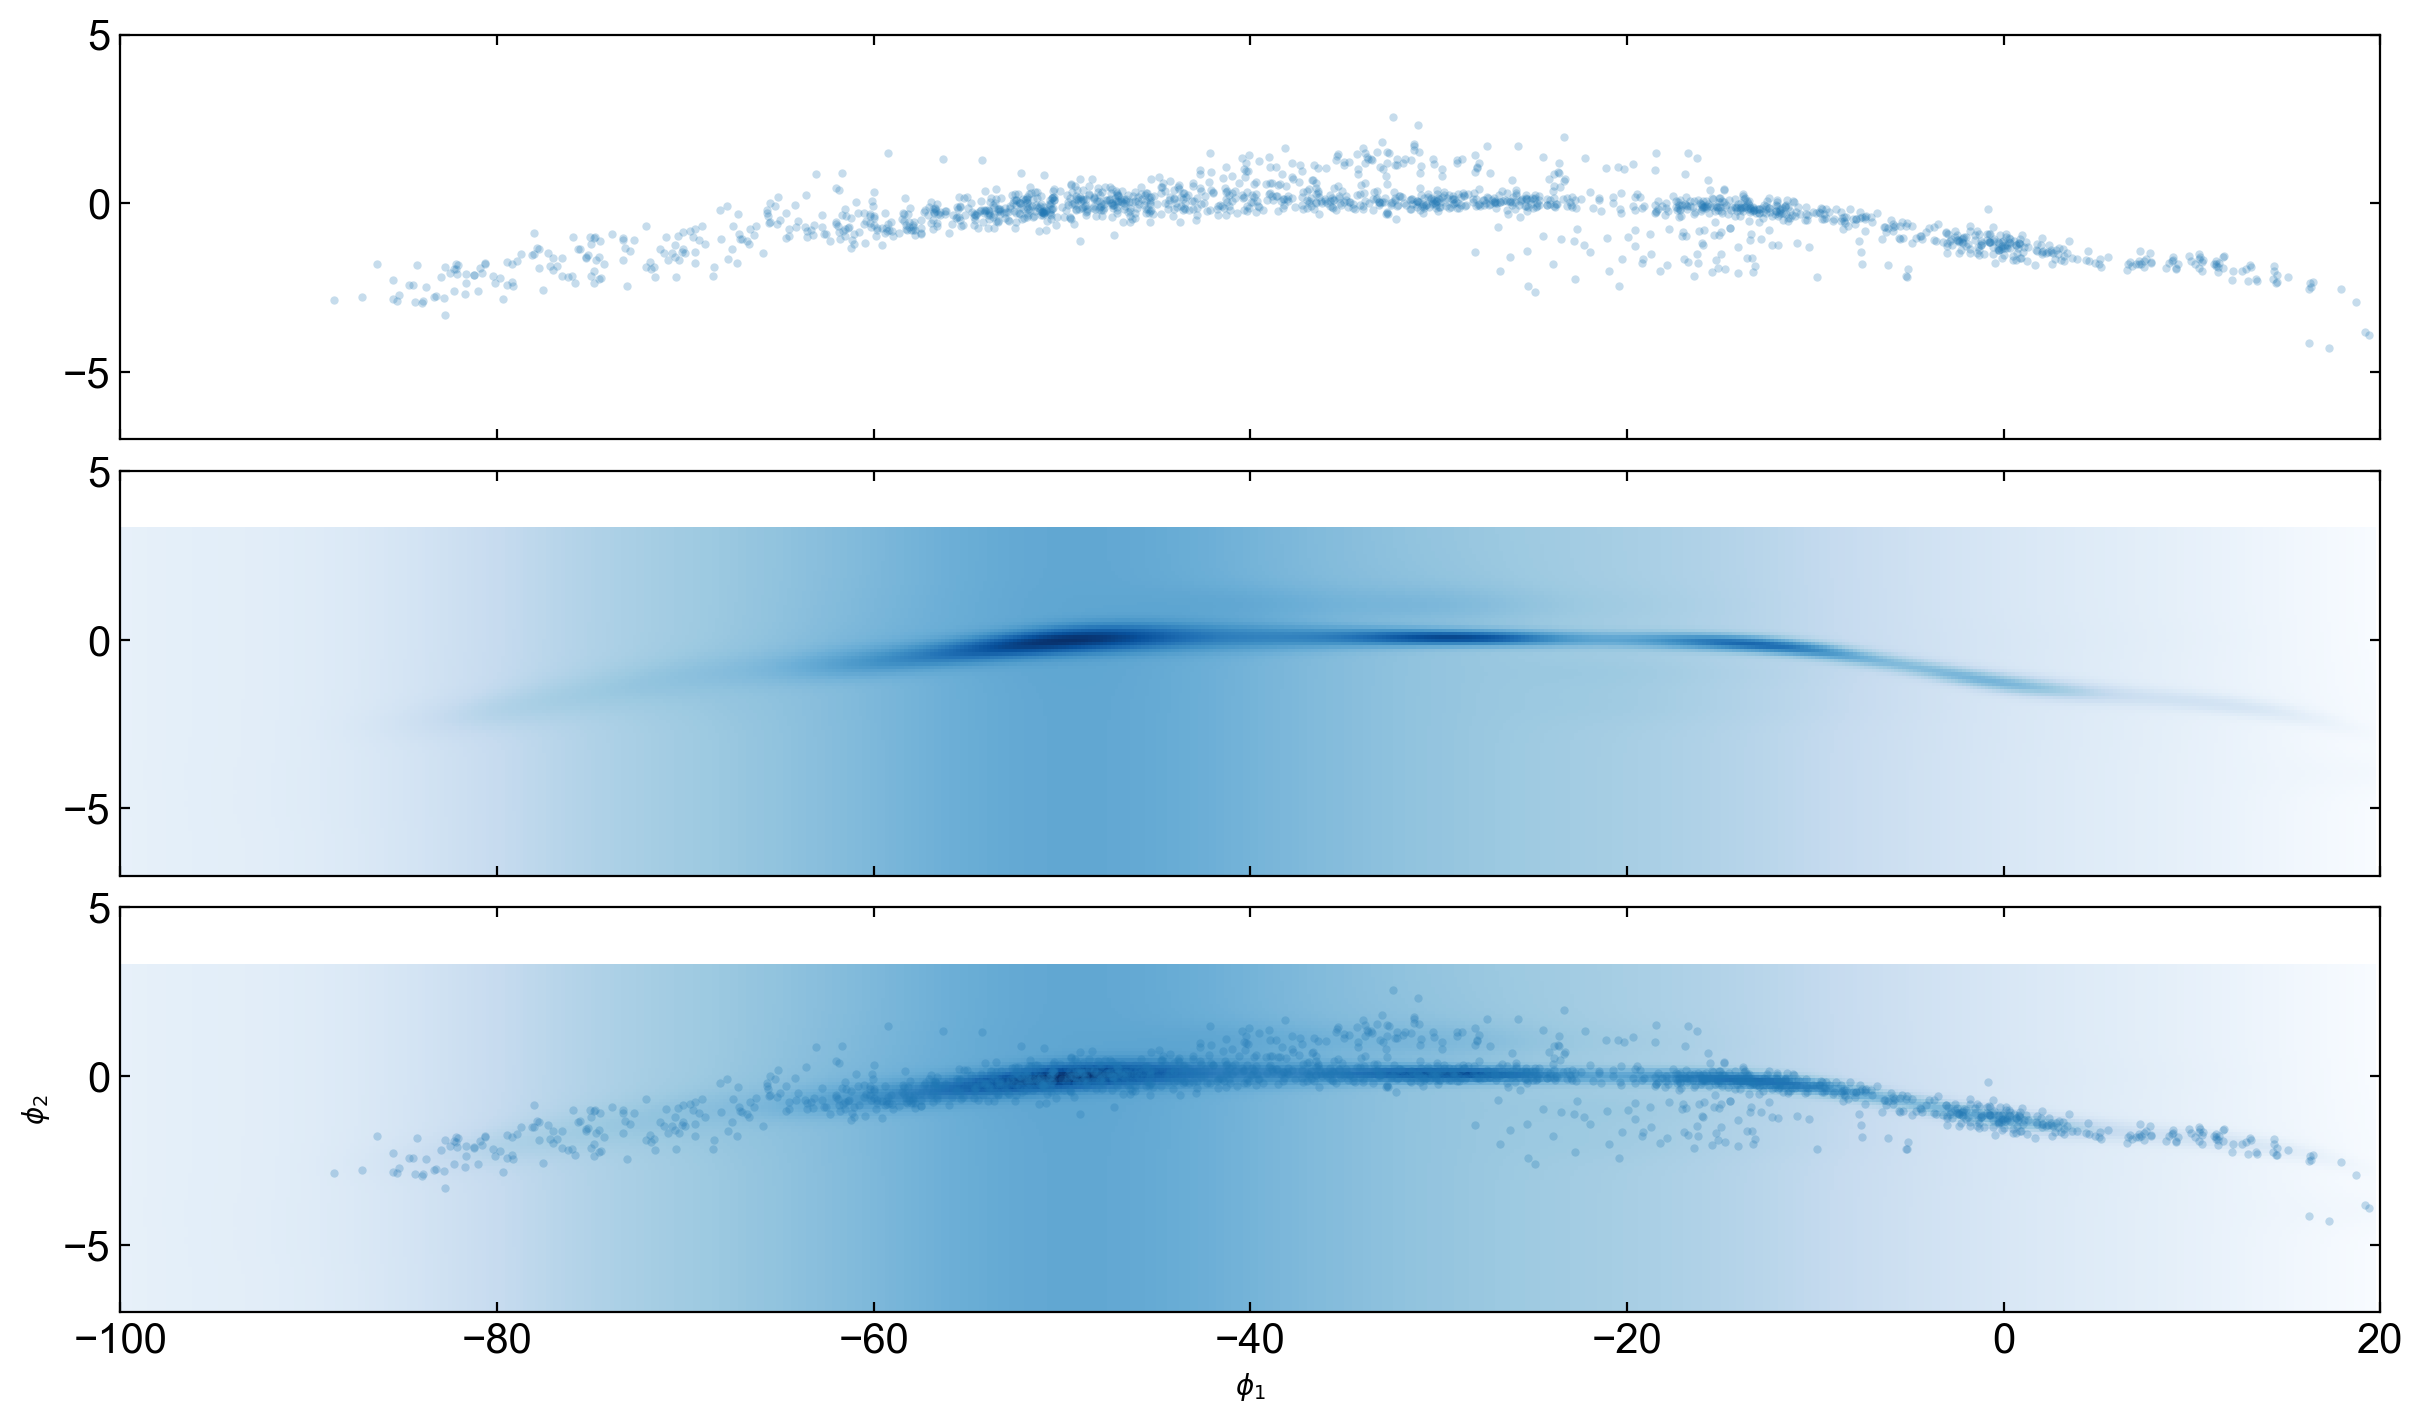

In [106]:
threshold = (final_memb_prob>0.5)

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)
for ax in [axes[0], axes[2]]:
    ax.plot(
        run_data['phi1'][threshold],
        run_data['phi2'][threshold],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

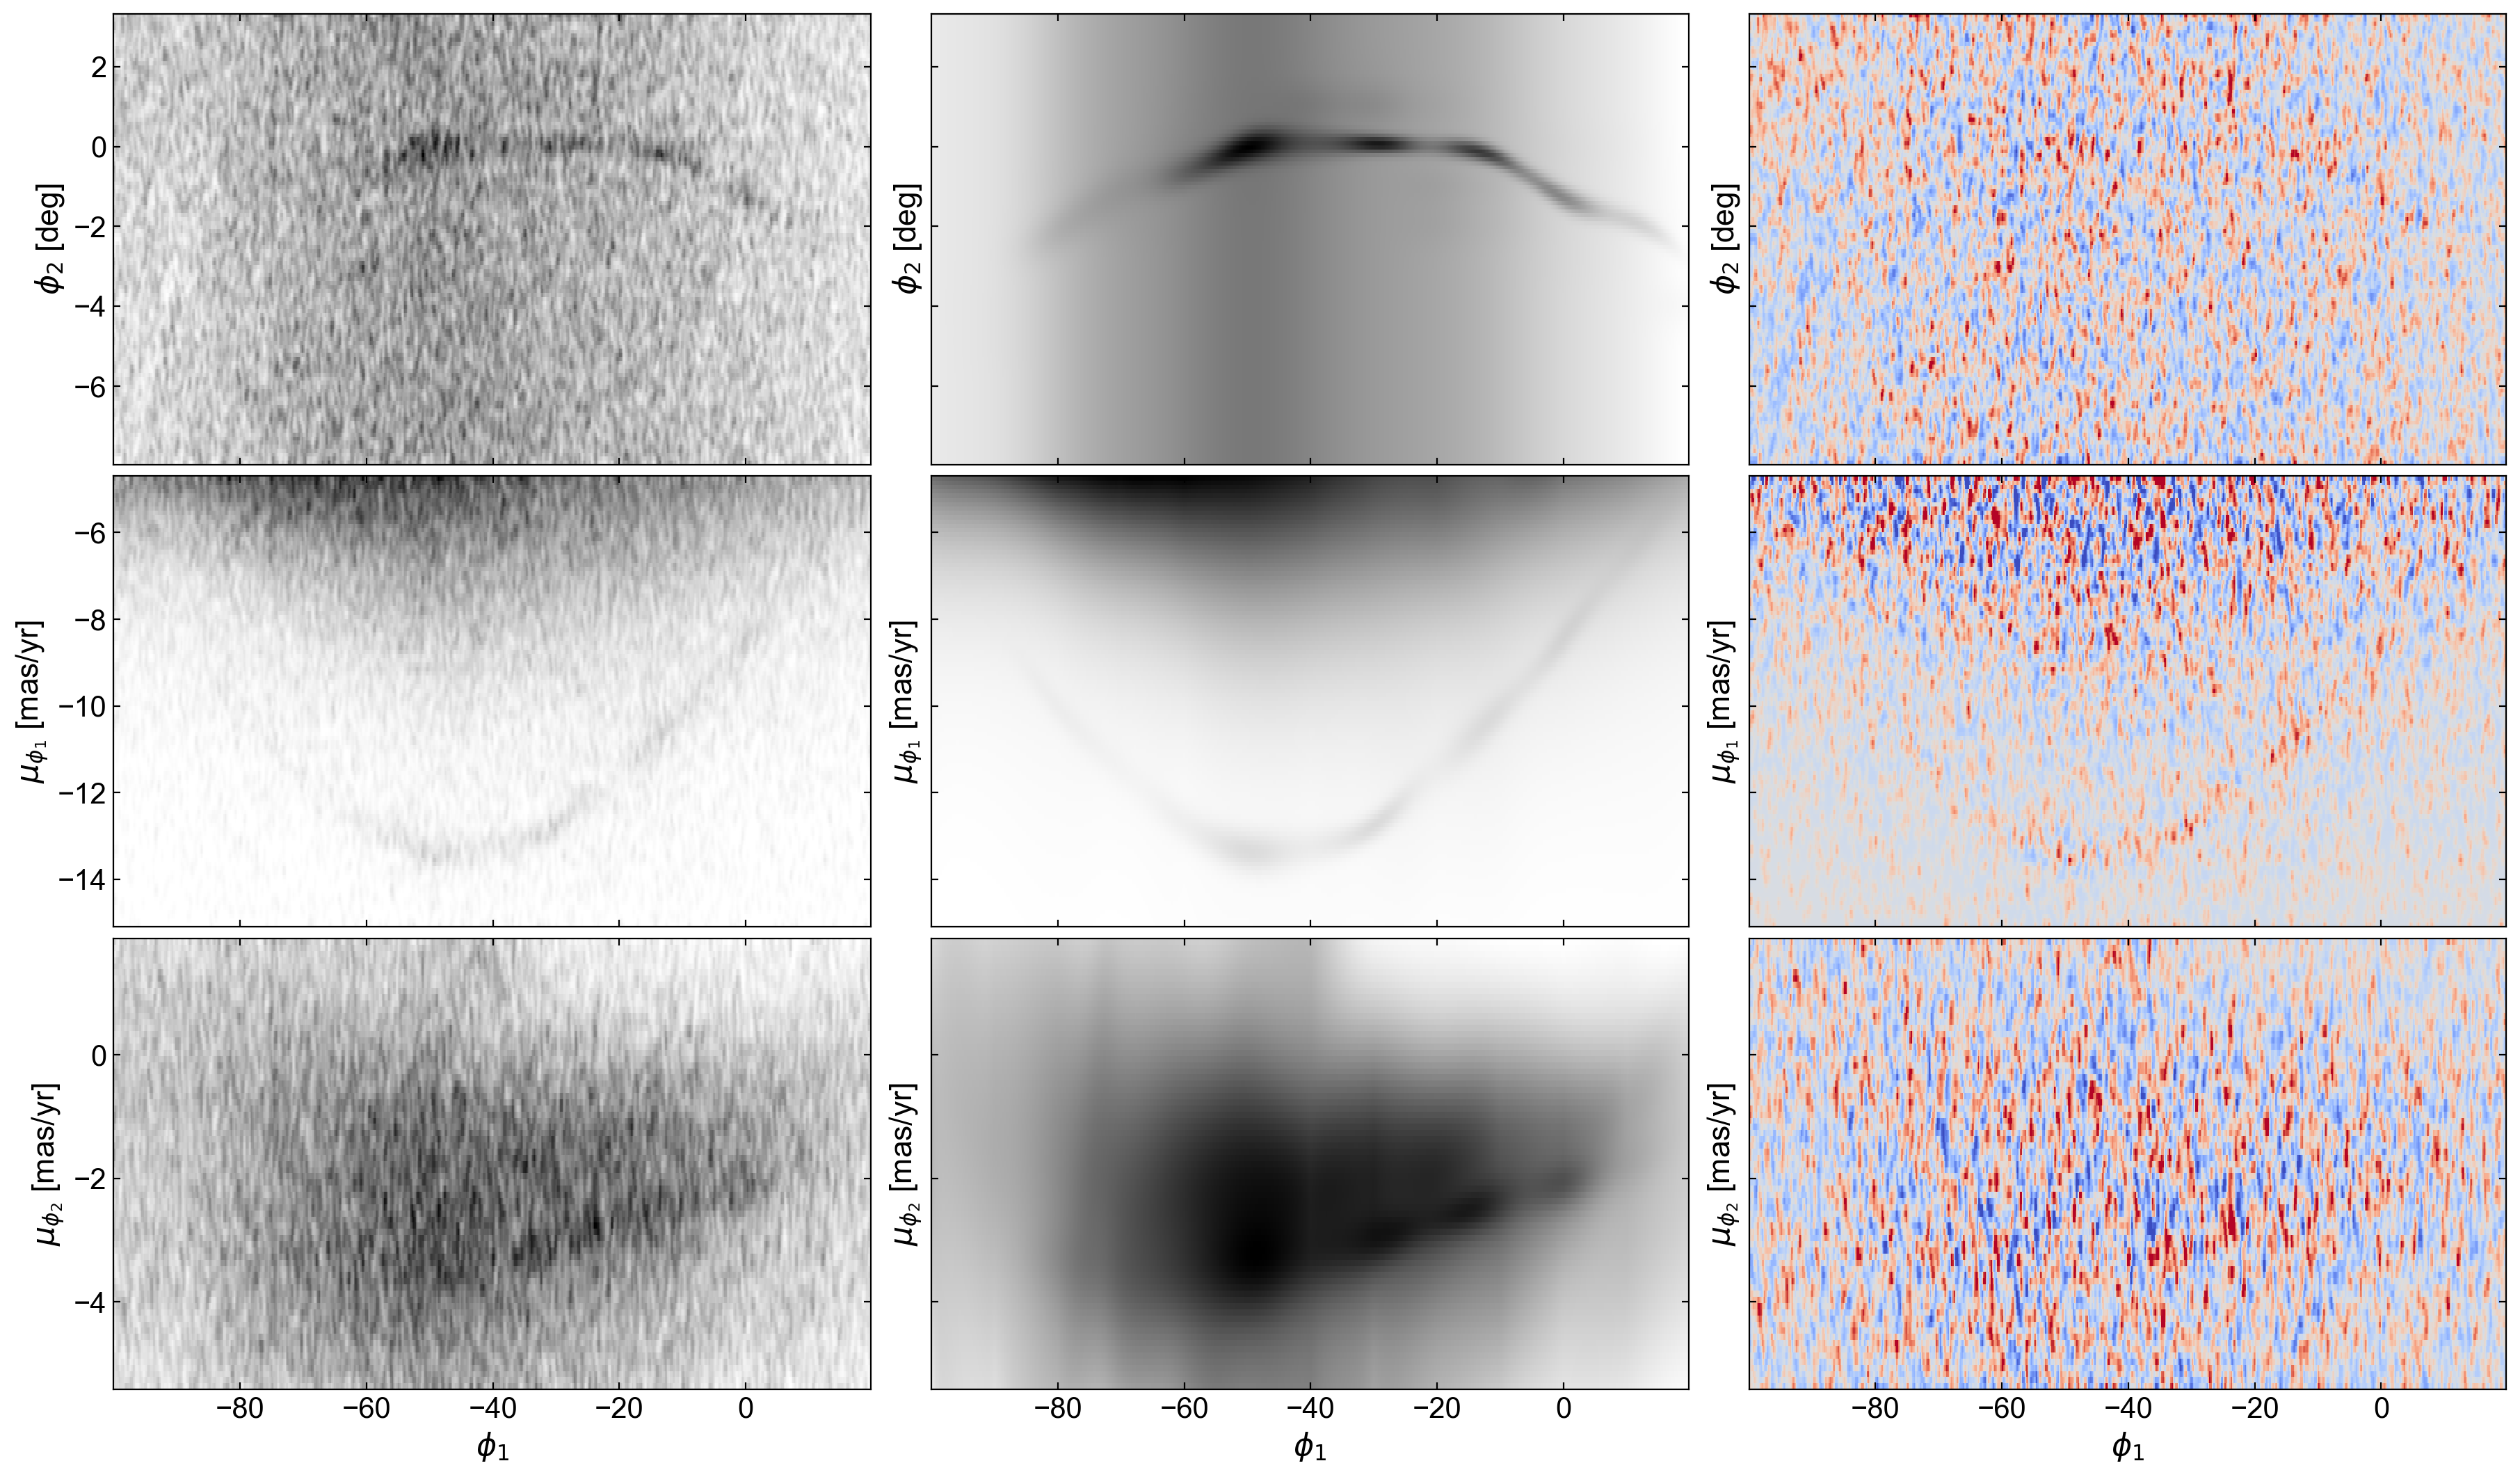

In [110]:
fig, axes = plt.subplots(
    len(full_mix_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(full_mix_nobkg_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=stream_opt.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

KeyError: 'phi1'

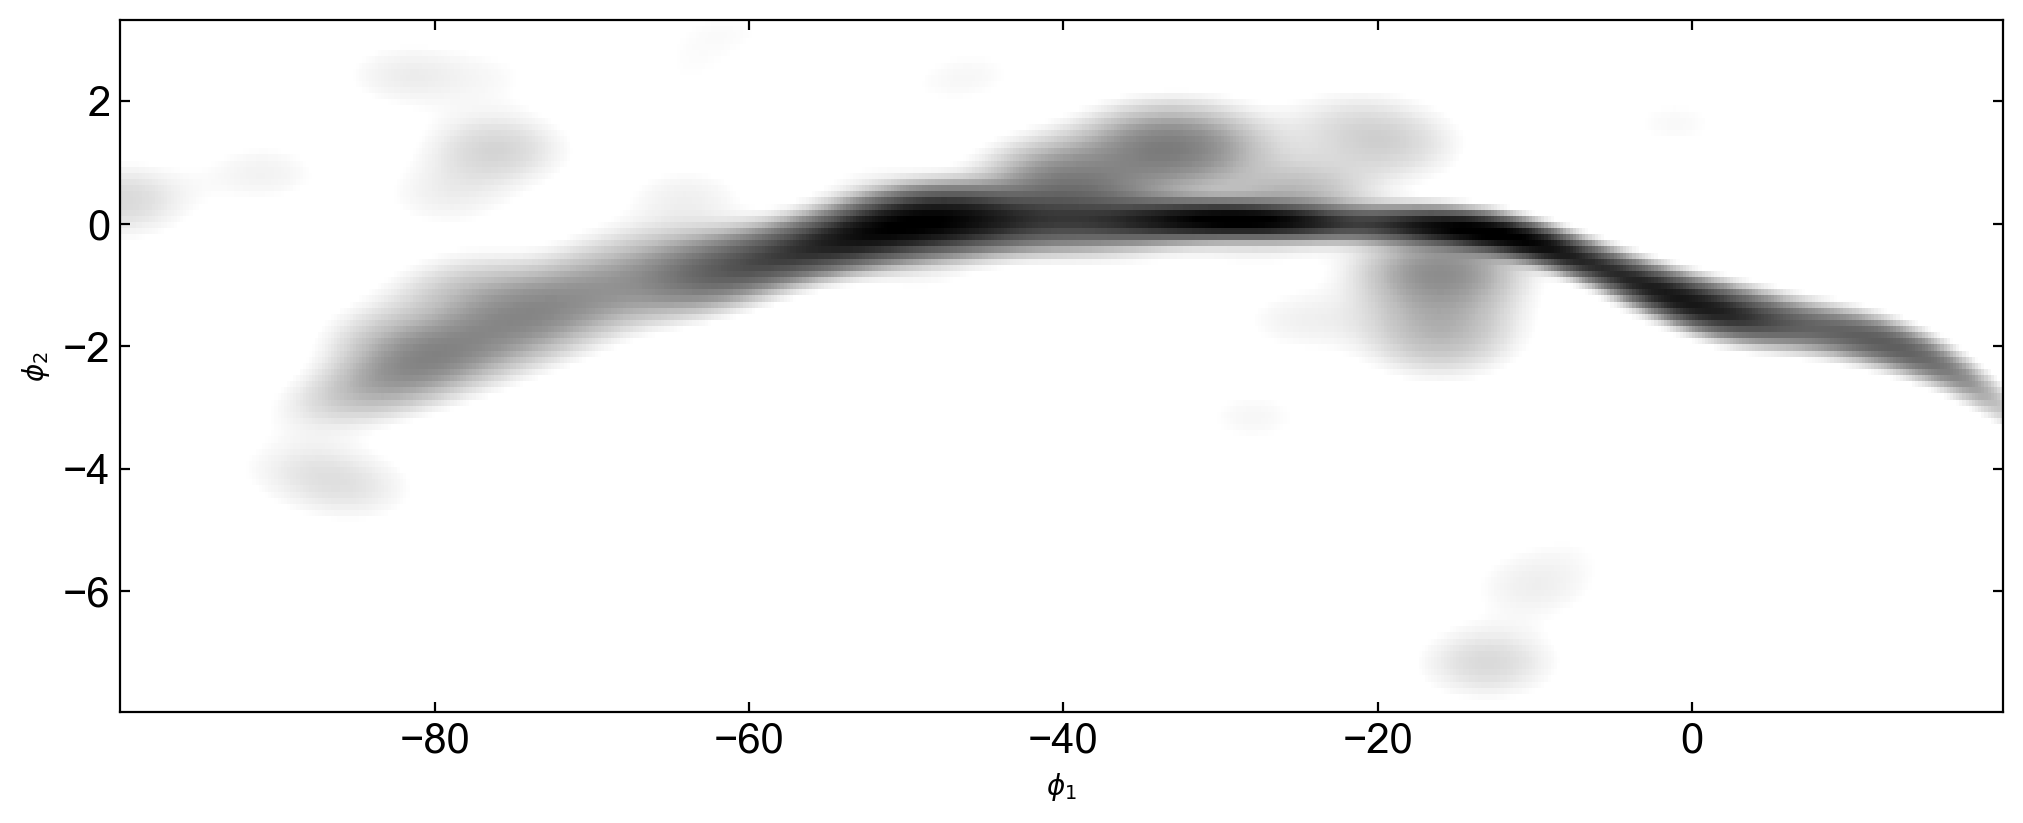

In [81]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[StreamDensModel, OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "pm1")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "pm2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

In [82]:
full_mix_opt.spar_steps

AttributeError: 'StreamMixtureModel' object has no attribute 'spar_steps'

KeyError: 'phi1'

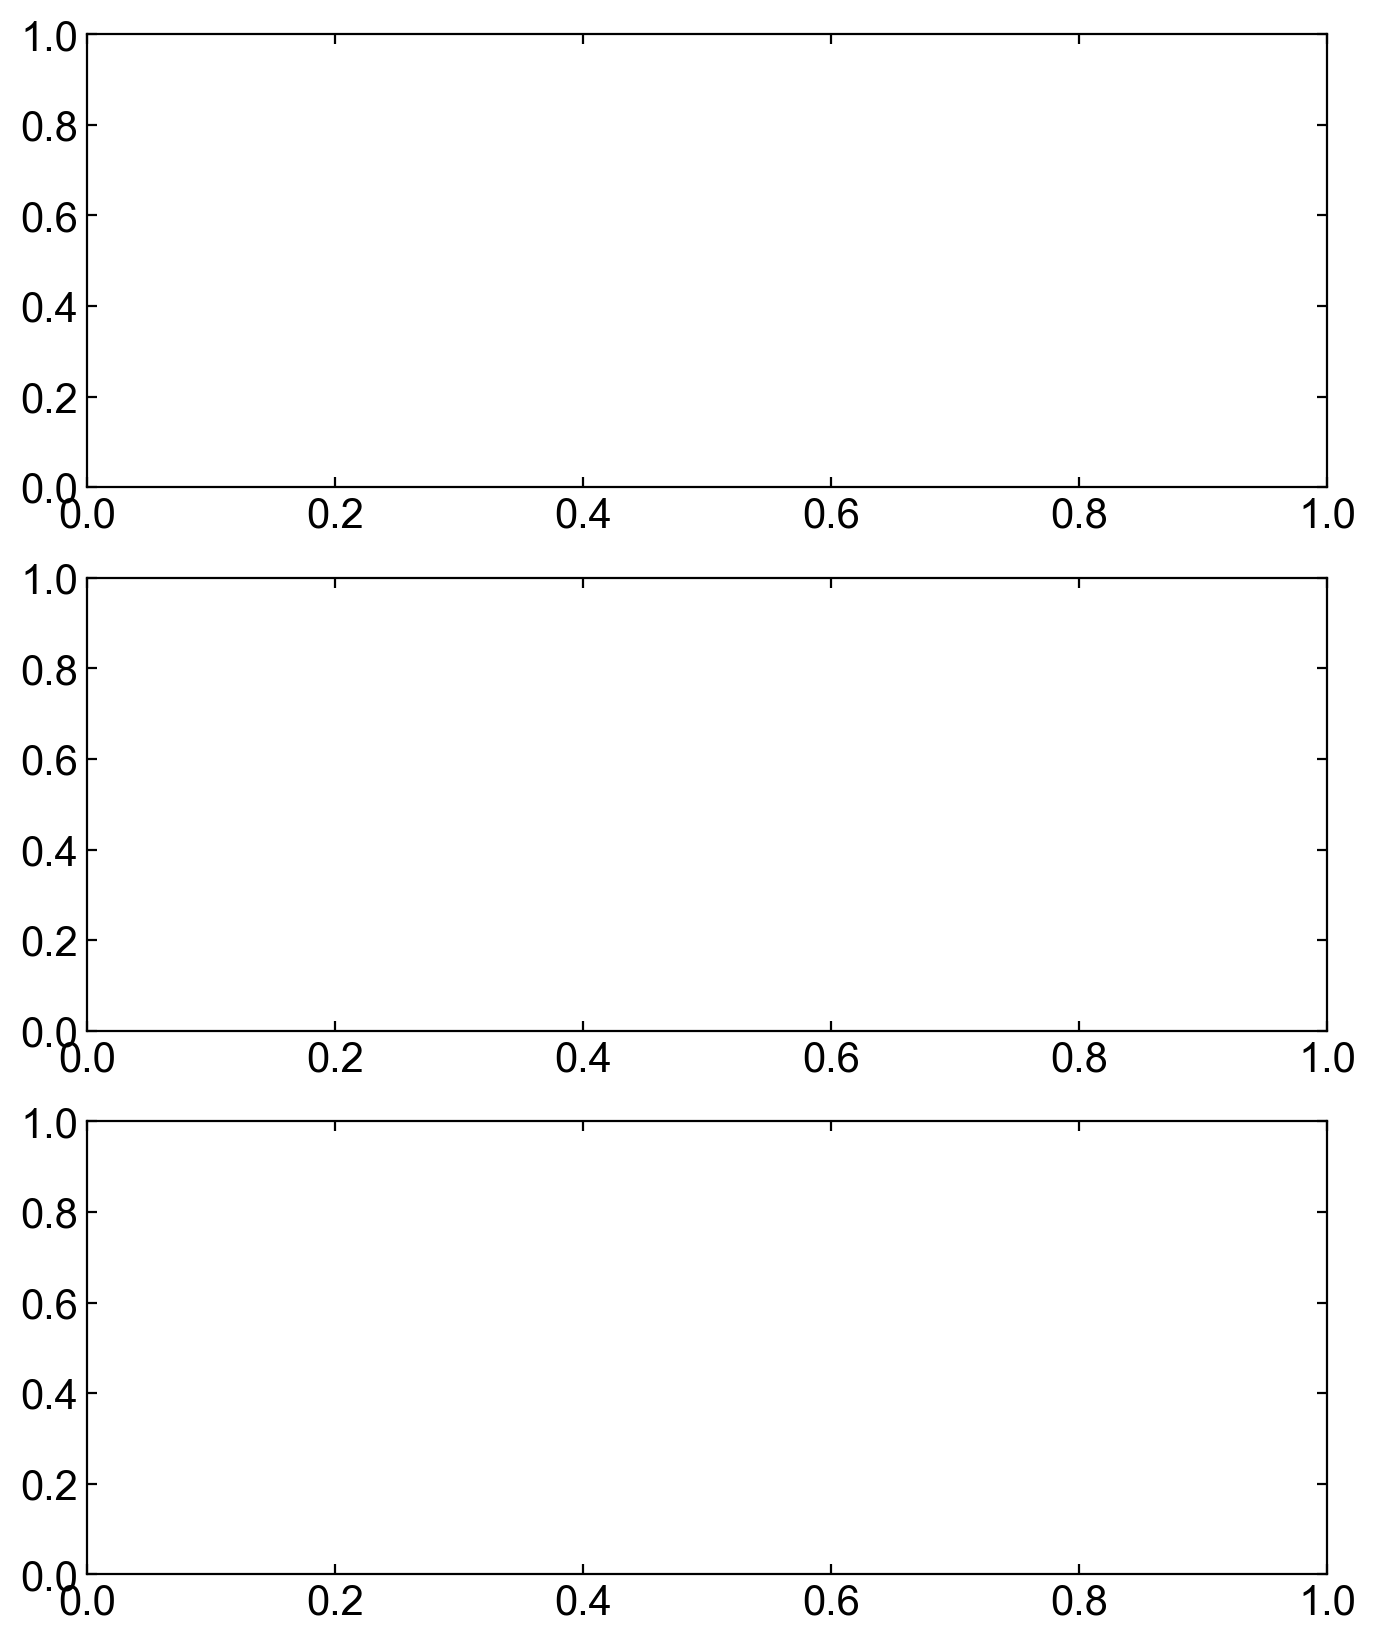

In [102]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_mix_nobkg_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

KeyError: 'phi1'

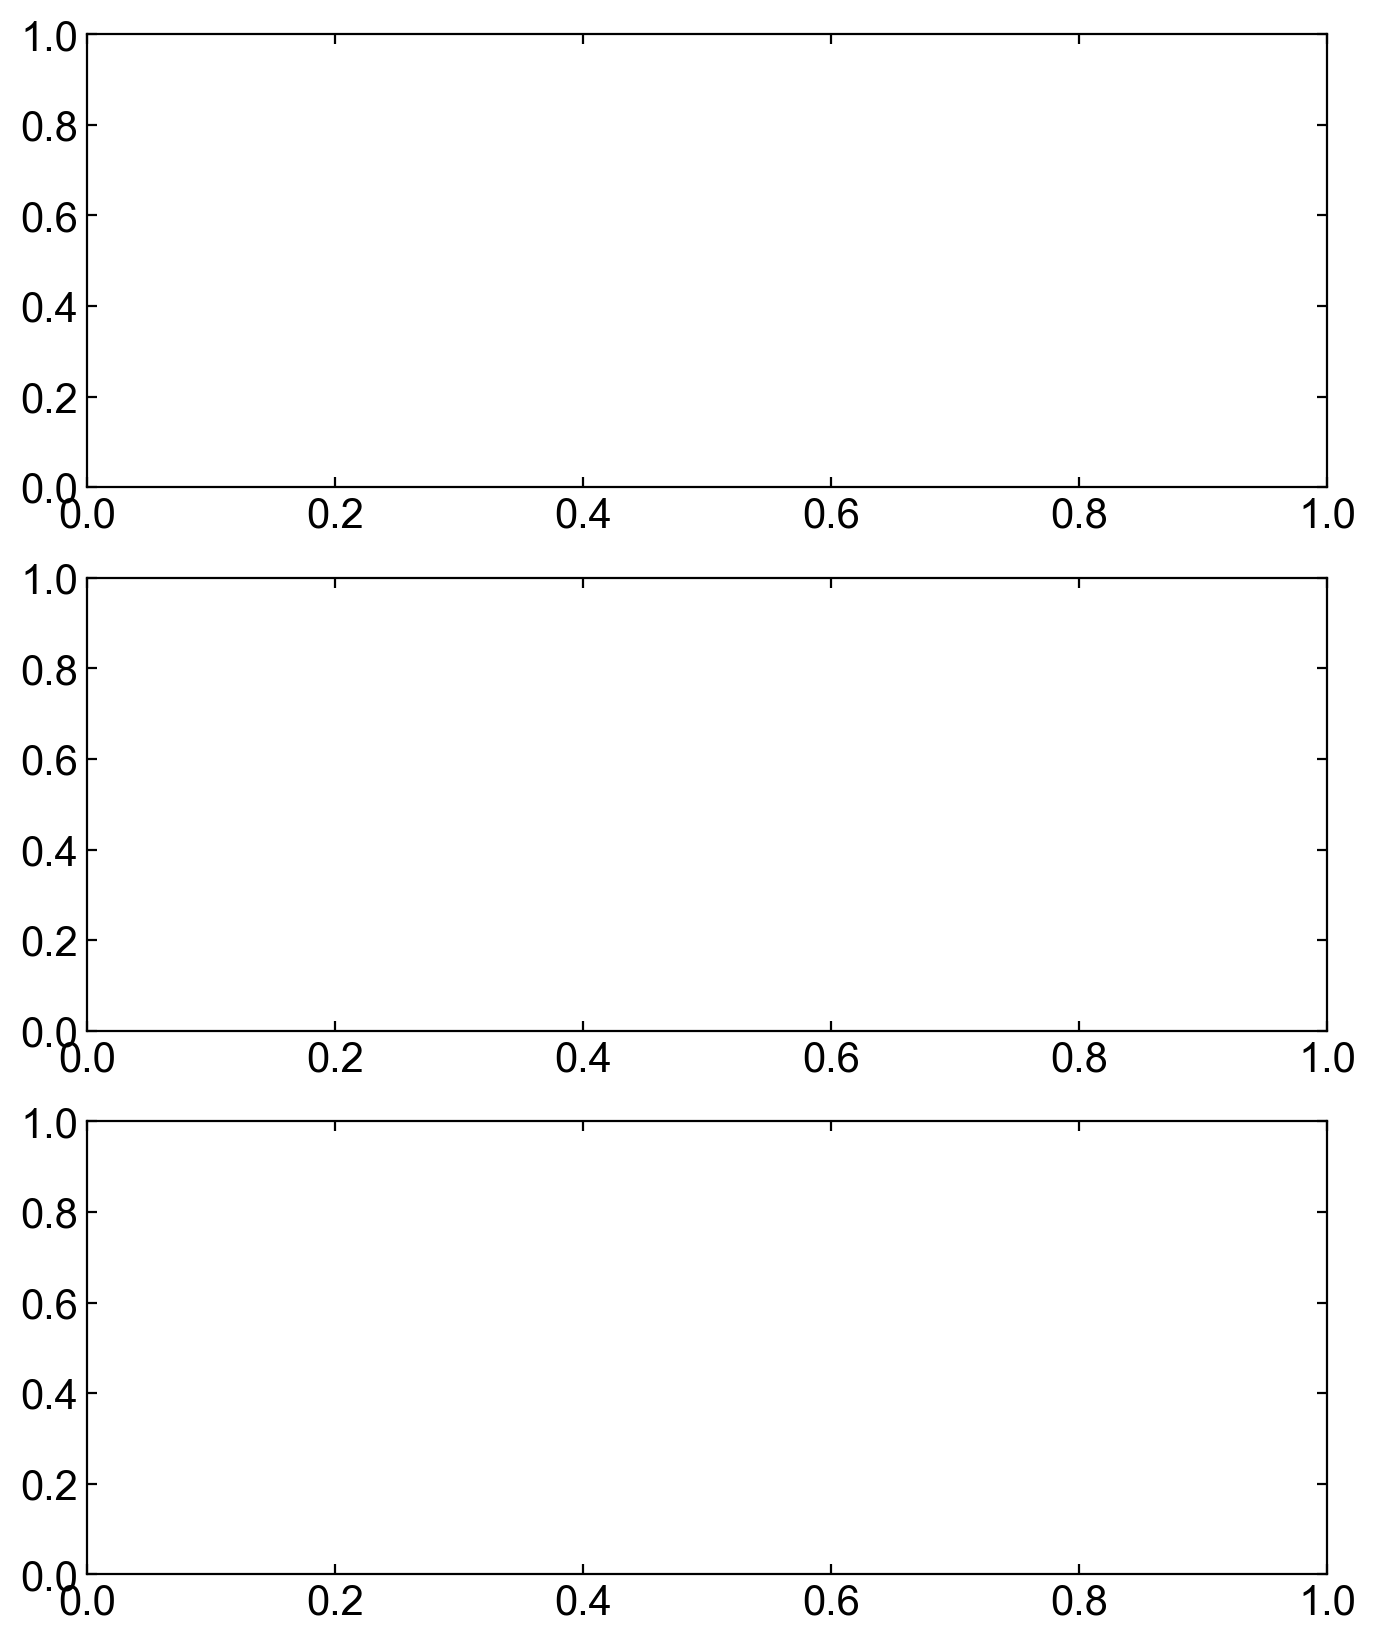

In [96]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_mix_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

KeyError: 'phi1'

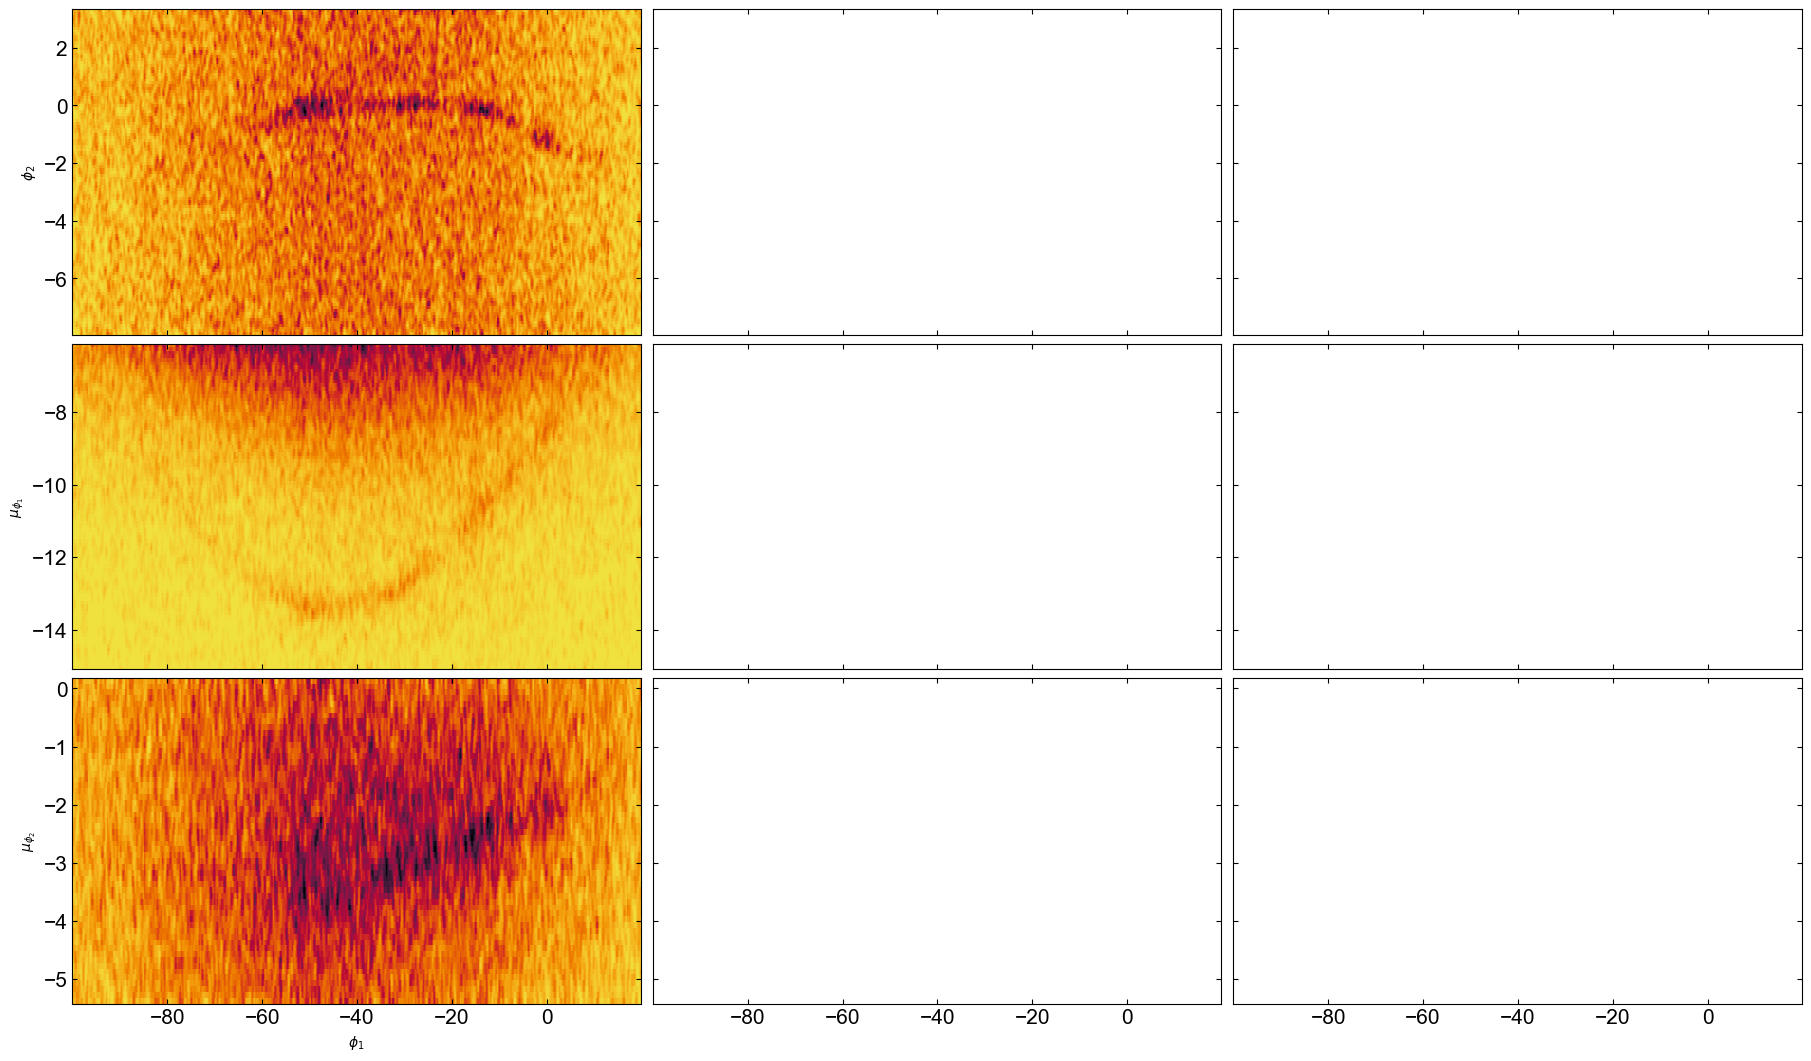

In [81]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)


axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt1.plot_model_projections(axes=axes[:, 1])
full_mix_opt1.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")